In [1]:
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 0,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

def volcano_plot_no_visualization(df,title, M=config['Magnitude (M)'], A=config['Altitude (A)'], method=config['method'], alpha=config['alpha'], logFC_threshold=config['logFC_threshold'], highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                upreg_criteria=config['upreg_criteria'], downreg_criteria=config['downreg_criteria'], upregulated_color=config['upregulated_color'], downregulated_color=config['downregulated_color'],
                                not_significant_color=config['not_significant_color'], not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                pie_chart_size=config['pie_chart_size'], pie_chart_position=config['pie_chart_position'], ranking_method=config['ranking_method'],up_or_down_or_both=config['up_or_down_or_both'],g100=config['g100'],g010=config['g010'],g001=config['g001'],g110=config['g110'],g101=config['g101'],g011=config['g011'],g111=config['g111']):


    method_to_column = {
        'PValue': 'PValue',
        'BH': 'BH_adjusted_p-value',
        'Bonferroni': 'Bonferroni_adjusted_p-value',  
        'BY': 'BY_adjusted_p-value',
        'Holm': 'Holm_adjusted_p-value',
        'Hochberg': 'Hochberg_adjusted_p-value',
        'adjusted_p-value': 'adjusted_p-value'
    }

    if ranking_method not in ['Corner', 'MAS']:
        raise ValueError("Invalid ranking_method. Valid options are 'corner' and 'MAS'")


    if ranking_method == 'Corner':
        ranked_df = Corner_ranking(df, method=method, alpha=alpha)
    else:
        ranked_df = MAS(df, M=M, A=A, method=method, alpha=alpha,logFC_threshold=logFC_threshold,up_or_down_or_both=up_or_down_or_both)


    y_column = method_to_column[method]
    ranked_df['-log10(P)'] = -np.log10(ranked_df[y_column])


    if method == 'Bonferroni':
        adjusted_alpha = alpha / len(df)
    else:
        adjusted_alpha = alpha

    significance_threshold = -np.log10(adjusted_alpha)
    
    if up_or_down_or_both=='Only_upregulated':
        significant_genes_criteria = (df['logFC'] > logFC_threshold) & (df[y_column] <= adjusted_alpha)
    elif up_or_down_or_both=='Only_downregulated':
        significant_genes_criteria = (df['logFC']< -logFC_threshold) & (df[y_column] <= adjusted_alpha)
    elif up_or_down_or_both=='both_up_and_down_regulated':
        significant_genes_criteria = (df['logFC'].abs() > logFC_threshold) & (df[y_column] <= adjusted_alpha)
    

    significant_genes = df[significant_genes_criteria]


    ranked_df['Category'] = 'Not Significant'
    ranked_df.loc[ranked_df.apply(lambda row: row['logFC'] >= logFC_threshold and row[y_column] <= adjusted_alpha, axis=1), 'Category'] = 'Upregulated'
    ranked_df.loc[ranked_df.apply(lambda row: row['logFC'] <= -logFC_threshold and row[y_column] <= adjusted_alpha, axis=1), 'Category'] = 'Downregulated'

    upreg_criteria = upreg_criteria if upreg_criteria is not None else lambda row: row[y_column] <= adjusted_alpha and row['logFC'] >= logFC_threshold
    downreg_criteria = downreg_criteria if downreg_criteria is not None else lambda row: row[y_column] <= adjusted_alpha and row['logFC'] <= -logFC_threshold

    ranked_df['Category'] = 'Not Significant'
    ranked_df.loc[ranked_df.apply(upreg_criteria, axis=1), 'Category'] = 'Upregulated'
    ranked_df.loc[ranked_df.apply(downreg_criteria, axis=1), 'Category'] = 'Downregulated'


    colors = {
        'Upregulated': upregulated_color,
        'Downregulated': downregulated_color,
        'Not Significant': not_significant_color,
        'Not Significant Between LogFC Threshold': not_significant_between_logFC_threshold_color
    }


    all_genes = ranked_df[ranked_df['Category'] != 'Not Significant Between LogFC Threshold']
    not_sig_between_genes = ranked_df[ranked_df['Category'] == 'Not Significant Between LogFC Threshold']
    method = config['method']
    ranking_method = config['ranking_method']
    
    if up_or_down_or_both=='Only_upregulated':       
        significance_criteria = (ranked_df['logFC'] > logFC_threshold) & (ranked_df[y_column] <= adjusted_alpha)
    elif up_or_down_or_both=='Only_downregulated':
        significance_criteria = (ranked_df['logFC'] < -logFC_threshold) & (ranked_df[y_column] <= adjusted_alpha)
    elif up_or_down_or_both=='both_up_and_down_regulated':
        significance_criteria = (ranked_df['logFC'].abs() > logFC_threshold) & (ranked_df[y_column] <= adjusted_alpha)
    significant = sum(significance_criteria)
    insignificant = len(ranked_df) - significant
    sizes = [significant, insignificant]
    labels = [
        f'Significant ({significant}) - {significant / len(ranked_df):.1%}',
        f'Insignificant ({insignificant}) - {insignificant / len(ranked_df):.1%}'
    ]
    
    labels2 = [
        f'',
        f''
    ]

    colors = ['lightgreen', 'gray']

    output_columns = ['Gene Symbol', 'logFC', 'PValue',  y_column]
    if ranking_method == 'Corner':
        output_columns += ['corner_rank', 'corner_distance']
    elif ranking_method == 'MAS':
        output_columns += ['MAS_rank', 'MAS_Score']

    output_df = ranked_df[output_columns]
    output_df = output_df.rename(columns={y_column: method})
    
    ranked_df['Category'] = 'Insignificant'
    ranked_df.loc[significance_criteria & (ranked_df['logFC'] > 0), 'Category'] = 'Upregulated'
    ranked_df.loc[significance_criteria & (ranked_df['logFC'] < 0), 'Category'] = 'Downregulated'

    significant_genes = ranked_df[ranked_df['Category'].isin(['Upregulated', 'Downregulated'])]

    if ranking_method == 'MAS':
        significant_genes = significant_genes.sort_values(by='MAS_Score', ascending=False).reset_index(drop=True)
        significant_genes['MAS_rank'] = significant_genes.index + 1  
    else:  # 'corner'
        x_max = df['logFC'].max()
        x_min = df['logFC'].min()
        maximum_x = max(abs(x_min), abs(x_max))
        y_max = ranked_df['-log10(P)'].max()

        def calculate_distance(row):
            x = row['logFC']
            y = row['-log10(P)']
            if x >= 0:
                return np.sqrt((x - maximum_x) ** 2 + (y - y_max) ** 2)
            else:
                return np.sqrt((x + maximum_x) ** 2 + (y - y_max) ** 2)

        significant_genes['corner_distance'] = significant_genes.apply(calculate_distance, axis=1)
        significant_genes = significant_genes.sort_values(by='corner_distance').reset_index(drop=True)
        significant_genes['corner_rank'] = significant_genes.index + 1

    return output_df, significant_genes

import numpy as np

def MAS(df,M,A, method, alpha, logFC_threshold,up_or_down_or_both):
    if method == 'PValue':
        y_column = 'PValue'
    elif method == 'BH':
        df['BH_adjusted_p-value'] = BH_adjusted_pvalue(df['PValue'].values, alpha)
        y_column = 'BH_adjusted_p-value'
    elif method == 'Bonferroni':
        bonferroni_alpha = alpha / len(df)
        df['Bonferroni_adjusted_p-value'] = df['PValue'] 
        y_column = 'Bonferroni_adjusted_p-value'
    elif method == 'BY':
        df['BY_adjusted_p-value'] = BY_adjusted_pvalue(df['PValue'].values, alpha)
        y_column = 'BY_adjusted_p-value'
    elif method == 'Holm':
        df['Holm_adjusted_p-value'] = Holm_adjusted_pvalue(df['PValue'].values, alpha)
        y_column = 'Holm_adjusted_p-value'
    elif method == 'Hochberg':
        df['Hochberg_adjusted_p-value'] = Hochberg_adjusted_pvalue(df['PValue'].values, alpha)
        y_column = 'Hochberg_adjusted_p-value'
    else:
        y_column = 'PValue'

    df[y_column] = df[y_column].clip(upper=1)

    adjusted_alpha = alpha / len(df) if method == 'Bonferroni' else alpha
    
    if up_or_down_or_both=='Only_upregulated':
              
        df['MAS_Score'] = np.where(
            (df['logFC'] > logFC_threshold) & (df[y_column] <= adjusted_alpha),
            (np.abs(df['logFC'])**M) * (np.abs(-np.log10(df[y_column]))**A),
            0
        )
    elif up_or_down_or_both=='Only_downregulated':
        df['MAS_Score'] = np.where(
            (df['logFC'] <- logFC_threshold) & (df[y_column] <= adjusted_alpha),
            (np.abs(df['logFC'])**M) * (np.abs(-np.log10(df[y_column]))**A),
            0
        )
    elif up_or_down_or_both=='both_up_and_down_regulated':
        df['MAS_Score'] = np.where(
            (df['logFC'].abs() > logFC_threshold) & (df[y_column] <= adjusted_alpha),
            (np.abs(df['logFC'])**M) * (np.abs(-np.log10(df[y_column]))**A),
            0
        )
        

    df = df.sort_values(by='MAS_Score', ascending=False).reset_index(drop=True)
    df['MAS_rank'] = df.index + 1

    return df
def BH_adjusted_pvalue(p, alpha):
    sort = np.argsort(p)
    rank = np.zeros(len(p))
    j = 1
    for i in range(len(sort)):
        rank[sort[i]] = j
        j = j + 1
    new_alpha = (rank / len(p)) * alpha

    L = []
    for j in range(len(rank)):
        if p[np.where(rank == len(rank) - j)[0][0]] < new_alpha[np.where(rank == len(rank) - j)[0][0]]:
            L.append(np.where(rank == len(rank) - j)[0][0])
    new_p = p * (len(p) / rank)
    H = np.zeros(len(p))
    H[np.where(rank == len(p))[0][0]] = new_p[np.where(rank == len(p))[0][0]]
    for k in range(1, len(p)):
        if new_p[np.where(rank == len(p) - k)[0][0]] > new_p[np.where(rank == len(p) - k + 1)[0][0]]:
            H[np.where(rank == len(p) - k)[0][0]] = new_p[np.where(rank == len(p) - k + 1)[0][0]]
        else:
            H[np.where(rank == len(p) - k)[0][0]] = new_p[np.where(rank == len(p) - k)[0][0]]
    
    BH_adjusted_p_values = np.where(H > 1, 1, H)
    
    return BH_adjusted_p_values

from matplotlib.ticker import MaxNLocator

import numpy as np
import matplotlib.pyplot as plt

def annotate_bars_vertical_with_totals(ax, positions, top_genes_up, top_genes_down, up_counts, down_counts, width):
    vertical_offset = 0.25  
    total_offset = 0.3  

    bbox_props = dict(boxstyle="round,pad=0.3", fc="seashell", ec="black", lw=1)

    for i, position in enumerate(positions):
        
        down_text = "\n".join(top_genes_down[f'BH'])
        ax.text(position + width/2, vertical_offset, down_text,
                ha='center', va='bottom', fontsize=22, color='black', rotation=0,
                transform=ax.get_xaxis_transform(), bbox=bbox_props)
        
        up_text = "\n".join(top_genes_up[f'BH'])
        ax.text(position - width/2, vertical_offset, up_text,
                ha='center', va='bottom', fontsize=22, color='black', rotation=0,
                transform=ax.get_xaxis_transform(), bbox=bbox_props)


        ax.text(position - width/2,  total_offset, f'Total: {down_counts[i]}',
                ha='center', va='bottom', fontsize=22, color='black', rotation=0)
        
        
        ax.text(position + width/2,  total_offset, f'Total: {up_counts[i]}',
                ha='center', va='bottom', fontsize=22, color='black', rotation=0)


In [2]:
import pandas as pd
from itertools import combinations

def get_top_genes_by_mas_rank(dataframes, group_names):
    """
    This function finds the top 10 genes for all unique and common gene sets based on the minimum of the maximum MAS Rank.
    
    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes containing gene data.
    - group_names (list of str): List of names for each group.
    
    Returns:
    - dict: A dictionary containing top 10 genes for each combination.
    """
    gene_sets = {name: set(df['Gene Symbol'].dropna().unique()) for name, df in zip(group_names, dataframes)}
    
    top_genes_results = {}

    def find_top_genes(df, genes):
        gene_rank_max = df[df['Gene Symbol'].isin(genes)].groupby('Gene Symbol')['MAS_rank'].max().reset_index()
        top_10_genes = gene_rank_max.nsmallest(30, 'MAS_rank')['Gene Symbol'].tolist()
        return top_10_genes

    for r in range(1, len(group_names) + 1):
        for combo in combinations(group_names, r):
            combo_name = ', '.join(combo)
            common_genes = set.intersection(*(gene_sets[group] for group in combo))
            other_groups = set(group_names).difference(combo)
            other_genes = set.union(*(gene_sets[group] for group in other_groups)) if other_groups else set()
            uniquely_common_genes = common_genes.difference(other_genes)

            if uniquely_common_genes:
                
                combined_df = pd.concat([dataframes[group_names.index(group)] for group in combo], ignore_index=True)
                top_genes = find_top_genes(combined_df, uniquely_common_genes)
                top_genes_results[combo_name] = top_genes

    return top_genes_results

In [3]:
import glob
import pandas as pd
import os

def read_csv_files_to_dict(directory):
    """
    Reads all CSV files matching the pattern 'DE_*_vs_*.csv' in the given directory,
    stores the data in DataFrames named after the CSV files (without extension),
    and creates a dictionary with file names as keys and DataFrames as values.

    Args:
        directory (str): Directory containing the CSV files.

    Returns:
        dict: A dictionary where keys are CSV file names (without extensions) and
              values are the corresponding pandas DataFrames.
    """
    pattern = os.path.join(directory, "BH_Significant*_*.csv")

    csv_files = glob.glob(pattern)

    if not csv_files:
        print("No matching files found in the directory.")
        return {}

    dataframes_dict = {}

    for file in csv_files:
        try:
            file_name = os.path.splitext(os.path.basename(file))[0]

            df = pd.read_csv(file)

            globals()[file_name] = df  

            dataframes_dict[file_name] = df

            print(f"Loaded DataFrame: {file_name} from {file}")

        except Exception as e:
            print(f"Error reading file {file}: {e}")

    return dataframes_dict

if __name__ == "__main__":

    current_directory = "./"  

    dataframes = read_csv_files_to_dict(current_directory)

    print("\nAccessing DataFrames:")
    for file_name, df in dataframes.items():
        print(f"\nDataFrame: {file_name}")
        print(df.head())  


Loaded DataFrame: BH_Significant_GSE157103_ICU from .\BH_Significant_GSE157103_ICU.csv
Loaded DataFrame: BH_Significant_GSE157103_NonICU from .\BH_Significant_GSE157103_NonICU.csv
Loaded DataFrame: BH_Significant_GSE171110 from .\BH_Significant_GSE171110.csv
Loaded DataFrame: BH_Significant_GSE189039 from .\BH_Significant_GSE189039.csv
Loaded DataFrame: BH_Significant_GSE201530 from .\BH_Significant_GSE201530.csv

Accessing DataFrames:

DataFrame: BH_Significant_GSE157103_ICU
  Gene Symbol     logFC    logCPM           F        PValue  \
0      CROCC2 -4.548336 -1.374310  139.461631  1.890000e-22   
1        ENHO -4.925319 -0.100859  127.806463  1.110000e-18   
2         IL4 -3.614938 -1.719797  127.603407  1.250000e-20   
3         SHD -4.066736 -2.508370   97.548554  1.700000e-16   
4      SLC4A3 -3.572072 -1.816849  103.852192  3.940000e-18   

   BH_adjusted_p-value  MAS_Score  MAS_rank     #NAME?       Category  
0         2.690000e-18  79.912044         1  17.569513  Downregulate

In [4]:
import glob
import pandas as pd
import os

def read_csv_files_to_dict(directory):
    """
    Reads all CSV files matching the pattern 'DE_*_vs_*.csv' in the given directory,
    stores the data in DataFrames named after the CSV files (without extension),
    and creates a dictionary with file names as keys and DataFrames as values.

    Args:
        directory (str): Directory containing the CSV files.

    Returns:
        dict: A dictionary where keys are CSV file names (without extensions) and
              values are the corresponding pandas DataFrames.
    """
    pattern = os.path.join(directory, "BH_Upregulated*_*.csv")

    csv_files = glob.glob(pattern)

    if not csv_files:
        print("No matching files found in the directory.")
        return {}

    dataframes_dict = {}

    for file in csv_files:
        try:
            file_name = os.path.splitext(os.path.basename(file))[0]

            df = pd.read_csv(file)

            globals()[file_name] = df  

            dataframes_dict[file_name] = df

            print(f"Loaded DataFrame: {file_name} from {file}")

        except Exception as e:
            print(f"Error reading file {file}: {e}")

    return dataframes_dict

if __name__ == "__main__":
    current_directory = "./" 

    dataframes_Up = read_csv_files_to_dict(current_directory)

    print("\nAccessing dataframes_Up:")
    for file_name, df in dataframes_Up.items():
        print(f"\nDataFrame: {file_name}")
        print(df.head())  


Loaded DataFrame: BH_Upregulated_GSE157103_ICU from .\BH_Upregulated_GSE157103_ICU.csv
Loaded DataFrame: BH_Upregulated_GSE157103_NonICU from .\BH_Upregulated_GSE157103_NonICU.csv
Loaded DataFrame: BH_Upregulated_GSE171110 from .\BH_Upregulated_GSE171110.csv
Loaded DataFrame: BH_Upregulated_GSE189039 from .\BH_Upregulated_GSE189039.csv
Loaded DataFrame: BH_Upregulated_GSE201530 from .\BH_Upregulated_GSE201530.csv

Accessing dataframes_Up:

DataFrame: BH_Upregulated_GSE157103_ICU
  Gene Symbol     logFC    logCPM          F        PValue  \
0       PCSK9  7.179852  2.384021  46.145172  2.160000e-09   
1       TOP2A  3.961832  3.785897  84.181653  4.610000e-13   
2        RRM2  3.532320  4.887627  98.423352  2.550000e-14   
3      DIAPH3  3.804728 -0.173845  79.373986  3.280000e-13   
4        SDC1  5.746970  1.637247  41.430721  1.160000e-08   

   BH_adjusted_p-value  MAS_Score  MAS_rank     #NAME?     Category  
0         1.360000e-07  49.302584         6   6.866797  Upregulated  
1  

In [5]:
import glob
import pandas as pd
import os

def read_csv_files_to_dict(directory):
    """
    Reads all CSV files matching the pattern 'DE_*_vs_*.csv' in the given directory,
    stores the data in DataFrames named after the CSV files (without extension),
    and creates a dictionary with file names as keys and DataFrames as values.

    Args:
        directory (str): Directory containing the CSV files.

    Returns:
        dict: A dictionary where keys are CSV file names (without extensions) and
              values are the corresponding pandas DataFrames.
    """
    pattern = os.path.join(directory, "BH_Downregulated*_*.csv")

    csv_files = glob.glob(pattern)

    if not csv_files:
        print("No matching files found in the directory.")
        return {}

    dataframes_dict = {}

    for file in csv_files:
        try:
   
            file_name = os.path.splitext(os.path.basename(file))[0]

            df = pd.read_csv(file)

            globals()[file_name] = df 

            dataframes_dict[file_name] = df

            print(f"Loaded DataFrame: {file_name} from {file}")

        except Exception as e:
            print(f"Error reading file {file}: {e}")

    return dataframes_dict

if __name__ == "__main__":
    current_directory = "./"  

    dataframes_Down = read_csv_files_to_dict(current_directory)

    print("\nAccessing dataframes_Down:")
    for file_name, df in dataframes_Down.items():
        print(f"\nDataFrame: {file_name}")
        print(df.head())  


Loaded DataFrame: BH_Downregulated_GSE157103_ICU from .\BH_Downregulated_GSE157103_ICU.csv
Loaded DataFrame: BH_Downregulated_GSE157103_NonICU from .\BH_Downregulated_GSE157103_NonICU.csv
Loaded DataFrame: BH_Downregulated_GSE171110 from .\BH_Downregulated_GSE171110.csv
Loaded DataFrame: BH_Downregulated_GSE189039 from .\BH_Downregulated_GSE189039.csv
Loaded DataFrame: BH_Downregulated_GSE201530 from .\BH_Downregulated_GSE201530.csv

Accessing dataframes_Down:

DataFrame: BH_Downregulated_GSE157103_ICU
  Gene Symbol     logFC    logCPM           F        PValue  \
0      CROCC2 -4.548336 -1.374310  139.461631  1.890000e-22   
1        ENHO -4.925319 -0.100859  127.806463  1.110000e-18   
2         IL4 -3.614938 -1.719797  127.603407  1.250000e-20   
3         SHD -4.066736 -2.508370   97.548554  1.700000e-16   
4      SLC4A3 -3.572072 -1.816849  103.852192  3.940000e-18   

   BH_adjusted_p-value  MAS_Score  MAS_rank     #NAME?       Category  
0         2.690000e-18  79.912044        

In [6]:


BH_Upregulated_GSE157103_ICU=dataframes_Up['BH_Upregulated_GSE157103_ICU']
BH_Upregulated_GSE157103_NonICU=dataframes_Up['BH_Upregulated_GSE157103_NonICU']


BH_Upregulated_GSE171110=dataframes_Up['BH_Upregulated_GSE171110']
BH_Upregulated_GSE189039=dataframes_Up['BH_Upregulated_GSE189039']
BH_Upregulated_GSE201530=dataframes_Up['BH_Upregulated_GSE201530']


In [7]:

BH_Downregulated_GSE157103_ICU=dataframes_Down['BH_Downregulated_GSE157103_ICU']
BH_Downregulated_GSE157103_NonICU=dataframes_Down['BH_Downregulated_GSE157103_NonICU']

BH_Downregulated_GSE171110=dataframes_Down['BH_Downregulated_GSE171110']
BH_Downregulated_GSE189039=dataframes_Down['BH_Downregulated_GSE189039']
BH_Downregulated_GSE201530=dataframes_Down['BH_Downregulated_GSE201530']


In [8]:
def analyze_gene_data(Data):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.ticker import MaxNLocator

    Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)

    title = 'Ranked Genes'
    config = {
        'method': 'BH',
        'alpha': 0.05,
        'logFC_threshold': 1,
        'up_or_down_or_both': 'both_up_and_down_regulated',
        'highlight_genes': [],
        'top_genes': 20,
        'upreg_criteria': None,
        'downreg_criteria': None,
        'upregulated_color': '#FF0000',
        'downregulated_color': '#0000FF',
        'not_significant_color': '#808080',
        'not_significant_between_logFC_threshold_color': '#A0A0A0',
        'pie_chart_size': 0.2,
        'pie_chart_position': (0.85, 0.85),
        'ranking_method': 'MAS',
        'Magnitude (M)': 1,
        'Altitude (A)': 1,
        'g100': (-1, 0.2),
        'g010': (1, 0.24),
        'g001': (-0.4, -0.5),
        'g110': (-0.6, 0.24),
        'g101': (-0.8, -0.3),
        'g011': (0.7, -0.1),
        'g111': (0.4, -0.6)
    }

    AllGenes, Significant = volcano_plot_no_visualization(
        Data,
        M=config['Magnitude (M)'],
        A=config['Altitude (A)'],
        title=title,
        method=config['method'],
        alpha=config['alpha'],
        logFC_threshold=config['logFC_threshold'],
        highlight_genes=config['highlight_genes'],
        top_genes=config['top_genes'],
        upreg_criteria=config['upreg_criteria'],
        downreg_criteria=config['downreg_criteria'],
        upregulated_color=config['upregulated_color'],
        downregulated_color=config['downregulated_color'],
        not_significant_color=config['not_significant_color'],
        not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
        pie_chart_size=config['pie_chart_size'],
        pie_chart_position=config['pie_chart_position'],
        ranking_method=config['ranking_method'],
        up_or_down_or_both=config['up_or_down_or_both'],
        g100=config['g100'], g010=config['g010'], g001=config['g001'],
        g110=config['g110'], g101=config['g101'], g011=config['g011'],
        g111=config['g111']
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 6))  

    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]

    positions = np.arange(1)
    width = 0.6

    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black', alpha=0.7, linewidth=1.2)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black', alpha=0.7, linewidth=1.2)

    ax.set_title("LogFC < -1 or LogFC > 1", fontsize=18, weight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels([], fontsize=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=16)

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }

    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist(),
    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': upregulated_counts,
            'Downregulated': downregulated_counts
        }
    }

    up_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    down_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]

    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, up_counts, down_counts, width)

    up_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.7)
    down_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.7)

    fig.legend(handles=[down_patch, up_patch], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.01), fontsize=16, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, .95])
    plt.show()

    return AllGenes, Significant


# GSE157103

In [9]:

ALL = pd.read_csv('GSE157103-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

dddata

,COVID-19 (1),COVID-19 (2),COVID-19 (3),COVID-19 (4),COVID-19 (5),COVID-19 (6),COVID-19 (7),Original strain ICU- USA -2020 (1),Original strain ICU- USA -2020 (2),Original strain ICU- USA -2020 (3),...,COVID-negative (1),COVID-negative (2),COVID-negative (3),COVID-negative (4),COVID-negative (5),COVID-negative (6),COVID-negative (7),COVID-negative (8),COVID-negative (9),COVID-negative (10)
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC112268260,65,35,125,75,243,43,46,86,73,47,...,43,160,69,30,104,58,33,101,49,17
OR4F29,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC105378947,3,4,7,7,19,3,4,8,5,2,...,1,11,1,1,7,1,2,3,3,1
OR4F16,10,7,19,9,59,13,7,26,18,7,...,1,45,18,6,20,7,4,9,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND4L,12250,9665,4030,18745,10515,11595,14496,12046,12580,10892,...,9155,12313,4243,16491,11447,8109,5829,5594,9518,3680
ND4,74728,80010,44163,140818,78660,124308,119453,102244,90604,126611,...,208390,113679,101620,192502,163742,194740,129232,128511,155324,70388
ND5,37774,37716,16412,80051,26916,56378,50230,41753,40158,39796,...,50116,44741,22272,68439,49426,48672,28568,30198,40846,18076


In [10]:
HLTY = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
NonICU = dddata[[col for col in dddata.columns if col.startswith('COVID-19')]]
ICU = dddata[[col for col in dddata.columns if col.startswith('Original strain ICU- USA -2020')]]


C:\Users\Mosta\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\Mosta\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:159: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


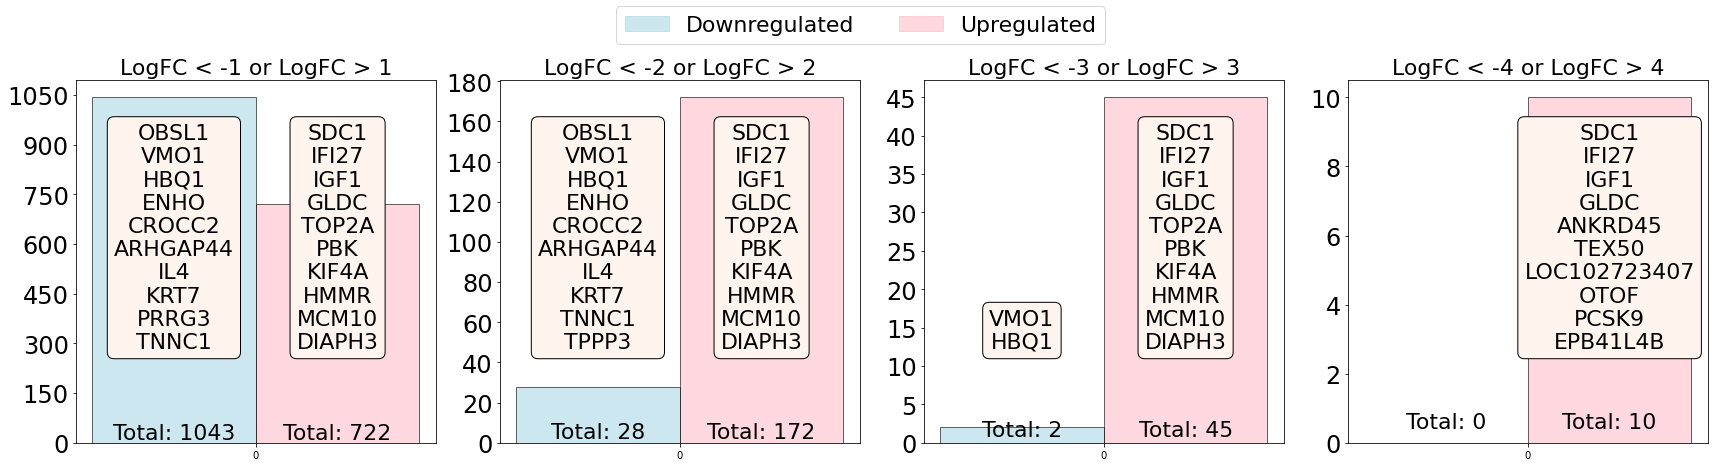

In [11]:
Data= dataframes['BH_Significant_GSE157103_NonICU']

Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)


title = "BH_Significant_GSE157103_NonICU"
config_Upset = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}



AllGenes_BH_Significant_GSE157103_NonICU, Significant_BH_Significant_GSE157103_NonICU = volcano_plot_no_visualization(Data, M=config_Upset['Magnitude (M)'], A=config_Upset['Altitude (A)'],
                                     title=title, method=config_Upset['method'], alpha=config_Upset['alpha'],
                                     logFC_threshold=config_Upset['logFC_threshold'],
                                     highlight_genes=config_Upset['highlight_genes'], top_genes=config_Upset['top_genes'],
                                     upreg_criteria=config_Upset['upreg_criteria'],
                                     downreg_criteria=config_Upset['downreg_criteria'],
                                     upregulated_color=config_Upset['upregulated_color'],
                                     downregulated_color=config_Upset['downregulated_color'],
                                     not_significant_color=config_Upset['not_significant_color'],
                                     not_significant_between_logFC_threshold_color=config_Upset['not_significant_between_logFC_threshold_color'],
                                     pie_chart_size=config_Upset['pie_chart_size'],
                                     pie_chart_position=config_Upset['pie_chart_position'],
                                     ranking_method=config_Upset['ranking_method'],
                                     up_or_down_or_both=config_Upset['up_or_down_or_both'],
                                     g100=config_Upset['g100'], g010=config_Upset['g010'], g001=config_Upset['g001'],
                                     g110=config_Upset['g110'], g101=config_Upset['g101'], g011=config_Upset['g011'],
                                     g111=config_Upset['g111'])

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

logFC_threshold_values = range(1,5) 


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten() 

title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 24}
label_font = {'family': 'arial', 'color': 'navy', 'weight': 'bold', 'size': 24}
title_font2 = {'family': 'serif', 'color': 'black',  'size': 24}

for idx, logFC_threshold in enumerate(logFC_threshold_values):
    ax = axs[idx]
    config['logFC_threshold'] = logFC_threshold
    
    AllGenes, Significant = volcano_plot_no_visualization(Data, M=config['Magnitude (M)'], A=config['Altitude (A)'],
                                         title=title, method=config['method'], alpha=config['alpha'],
                                         logFC_threshold=config['logFC_threshold'],
                                         highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                         upreg_criteria=config['upreg_criteria'],
                                         downreg_criteria=config['downreg_criteria'],
                                         upregulated_color=config['upregulated_color'],
                                         downregulated_color=config['downregulated_color'],
                                         not_significant_color=config['not_significant_color'],
                                         not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                         pie_chart_size=config['pie_chart_size'],
                                         pie_chart_position=config['pie_chart_position'],
                                         ranking_method=config['ranking_method'],
                                         up_or_down_or_both=config['up_or_down_or_both'],
                                         g100=config['g100'], g010=config['g010'], g001=config['g001'],
                                         g110=config['g110'], g101=config['g101'], g011=config['g011'],
                                         g111=config['g111'])
    
    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]
    
    positions = np.arange(1) 
    width = 1

  
    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black',alpha=.6)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black',alpha=.6)
    if logFC_threshold == 0:
        title = f"LogFC < {logFC_threshold} or LogFC > {logFC_threshold}"
    else:
        title = f"LogFC < -{logFC_threshold} or LogFC > {logFC_threshold}"

    ax.set_title(title, fontsize=22)

    ax.set_xticks(positions)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=24) 
 

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }
    
    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist()

    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': Significant[Significant['Category'] == 'Upregulated'].shape[0],
            'Downregulated': Significant[Significant['Category'] =='Downregulated'].shape[0]
        }
    }

    upregulated_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    downregulated_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats] 
    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, upregulated_counts, downregulated_counts, width)



upregulated_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.6)
downregulated_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.6)

fig.legend(handles=[downregulated_patch, upregulated_patch], loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.1), fontsize=22)

plt.tight_layout(rect=[0, 0, 1, .98])  

plt.show()




Processing file: BH_Significant_GSE157103_NonICU.csv


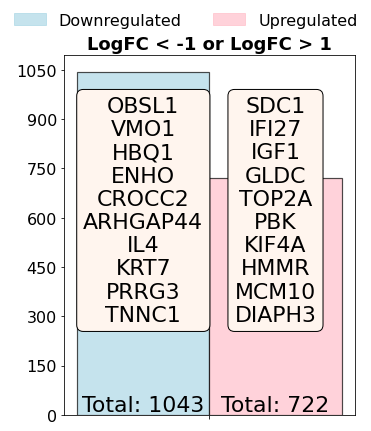

In [12]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')

def load_and_process_data():
    file_names = ['BH_Significant_GSE157103_NonICU.csv']
    current_dir = os.getcwd()  

    for file_name in file_names:
        file_path = os.path.join(current_dir, file_name)

        if os.path.exists(file_path):
            print(f"Processing file: {file_name}")
            data = pd.read_csv(file_path)
            all_genes, significant_genes = analyze_gene_data(data)  

            new_base_name = file_name.replace('DE_', 'Ranked_DE_')

        else:
            print(f"File not found: {file_name}")


load_and_process_data()


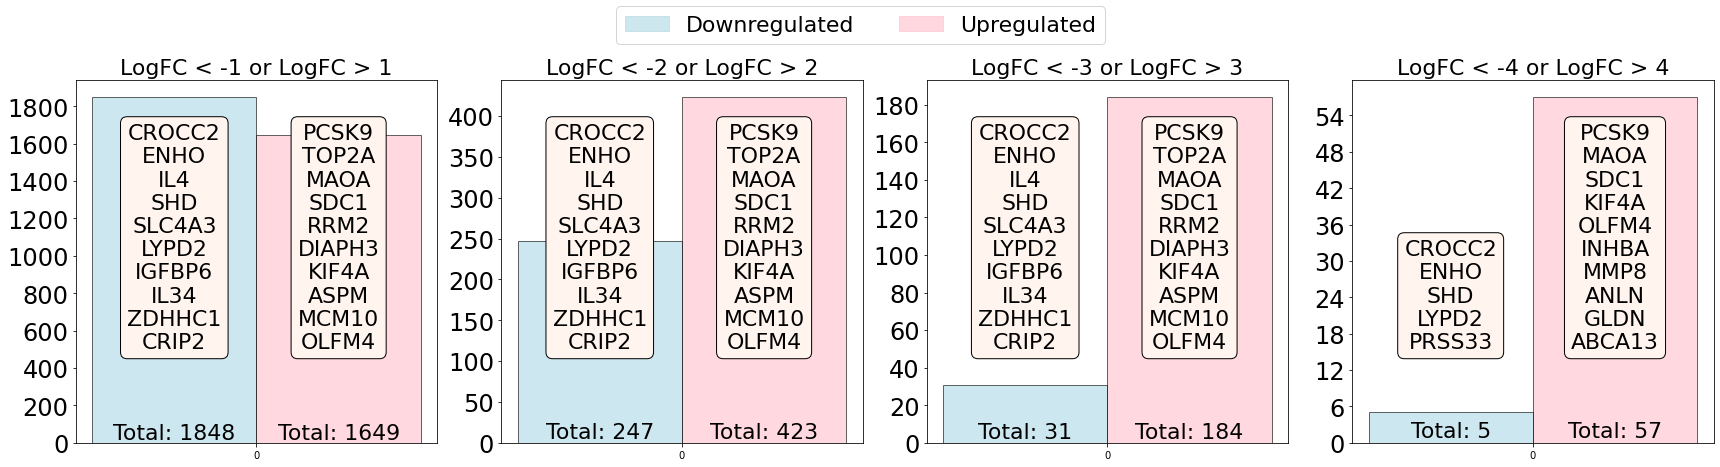

In [13]:
Data= dataframes['BH_Significant_GSE157103_ICU']

Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)


title = "BH_Significant_GSE157103_ICU"
config_Upset = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}



AllGenes_BH_Significant_GSE157103_ICU, Significant_BH_Significant_GSE157103_ICU = volcano_plot_no_visualization(Data, M=config_Upset['Magnitude (M)'], A=config_Upset['Altitude (A)'],
                                     title=title, method=config_Upset['method'], alpha=config_Upset['alpha'],
                                     logFC_threshold=config_Upset['logFC_threshold'],
                                     highlight_genes=config_Upset['highlight_genes'], top_genes=config_Upset['top_genes'],
                                     upreg_criteria=config_Upset['upreg_criteria'],
                                     downreg_criteria=config_Upset['downreg_criteria'],
                                     upregulated_color=config_Upset['upregulated_color'],
                                     downregulated_color=config_Upset['downregulated_color'],
                                     not_significant_color=config_Upset['not_significant_color'],
                                     not_significant_between_logFC_threshold_color=config_Upset['not_significant_between_logFC_threshold_color'],
                                     pie_chart_size=config_Upset['pie_chart_size'],
                                     pie_chart_position=config_Upset['pie_chart_position'],
                                     ranking_method=config_Upset['ranking_method'],
                                     up_or_down_or_both=config_Upset['up_or_down_or_both'],
                                     g100=config_Upset['g100'], g010=config_Upset['g010'], g001=config_Upset['g001'],
                                     g110=config_Upset['g110'], g101=config_Upset['g101'], g011=config_Upset['g011'],
                                     g111=config_Upset['g111'])

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

logFC_threshold_values = range(1,5)  


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten() 

title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 24}
label_font = {'family': 'arial', 'color': 'navy', 'weight': 'bold', 'size': 24}
title_font2 = {'family': 'serif', 'color': 'black',  'size': 24}

for idx, logFC_threshold in enumerate(logFC_threshold_values):
    ax = axs[idx]
    config['logFC_threshold'] = logFC_threshold
    
    AllGenes, Significant = volcano_plot_no_visualization(Data, M=config['Magnitude (M)'], A=config['Altitude (A)'],
                                         title=title, method=config['method'], alpha=config['alpha'],
                                         logFC_threshold=config['logFC_threshold'],
                                         highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                         upreg_criteria=config['upreg_criteria'],
                                         downreg_criteria=config['downreg_criteria'],
                                         upregulated_color=config['upregulated_color'],
                                         downregulated_color=config['downregulated_color'],
                                         not_significant_color=config['not_significant_color'],
                                         not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                         pie_chart_size=config['pie_chart_size'],
                                         pie_chart_position=config['pie_chart_position'],
                                         ranking_method=config['ranking_method'],
                                         up_or_down_or_both=config['up_or_down_or_both'],
                                         g100=config['g100'], g010=config['g010'], g001=config['g001'],
                                         g110=config['g110'], g101=config['g101'], g011=config['g011'],
                                         g111=config['g111'])
    
    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]
    
    positions = np.arange(1)  
    width = 1

 
    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black',alpha=.6)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black',alpha=.6)
    if logFC_threshold == 0:
        title = f"LogFC < {logFC_threshold} or LogFC > {logFC_threshold}"
    else:
        title = f"LogFC < -{logFC_threshold} or LogFC > {logFC_threshold}"

    ax.set_title(title, fontsize=22)

    ax.set_xticks(positions)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=24) 
 

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }
    
    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist()

    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': Significant[Significant['Category'] == 'Upregulated'].shape[0],
            'Downregulated': Significant[Significant['Category'] =='Downregulated'].shape[0]
        }
    }

    upregulated_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    downregulated_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]  
    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, upregulated_counts, downregulated_counts, width)



upregulated_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.6)
downregulated_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.6)

fig.legend(handles=[downregulated_patch, upregulated_patch], loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.1), fontsize=22)

plt.tight_layout(rect=[0, 0, 1, .98])  

plt.show()




Processing file: BH_Significant_GSE157103_ICU.csv


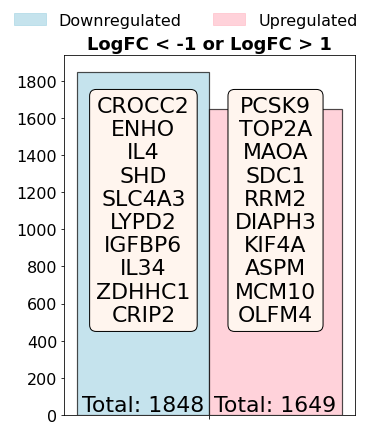

In [14]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')

def load_and_process_data():
    file_names = ['BH_Significant_GSE157103_ICU.csv']
    current_dir = os.getcwd()  

    for file_name in file_names:
        file_path = os.path.join(current_dir, file_name)

        if os.path.exists(file_path):
            print(f"Processing file: {file_name}")
            data = pd.read_csv(file_path)
            all_genes, significant_genes = analyze_gene_data(data)  

            new_base_name = file_name.replace('DE_', 'Ranked_DE_')

        else:
            print(f"File not found: {file_name}")


load_and_process_data()


# GSE171110

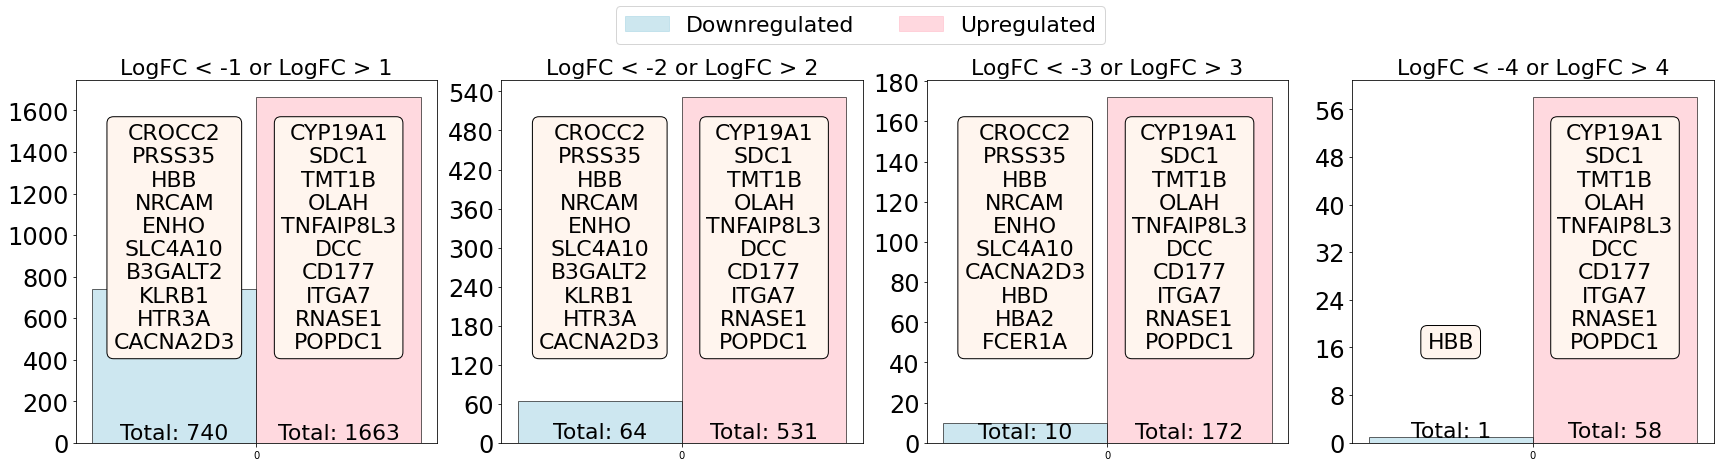

In [15]:
Data= dataframes['BH_Significant_GSE171110']

Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)


title = "BH_Significant_GSE171110"
config_Upset = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}



AllGenes_BH_Significant_GSE171110, Significant_BH_Significant_GSE171110 = volcano_plot_no_visualization(Data, M=config_Upset['Magnitude (M)'], A=config_Upset['Altitude (A)'],
                                     title=title, method=config_Upset['method'], alpha=config_Upset['alpha'],
                                     logFC_threshold=config_Upset['logFC_threshold'],
                                     highlight_genes=config_Upset['highlight_genes'], top_genes=config_Upset['top_genes'],
                                     upreg_criteria=config_Upset['upreg_criteria'],
                                     downreg_criteria=config_Upset['downreg_criteria'],
                                     upregulated_color=config_Upset['upregulated_color'],
                                     downregulated_color=config_Upset['downregulated_color'],
                                     not_significant_color=config_Upset['not_significant_color'],
                                     not_significant_between_logFC_threshold_color=config_Upset['not_significant_between_logFC_threshold_color'],
                                     pie_chart_size=config_Upset['pie_chart_size'],
                                     pie_chart_position=config_Upset['pie_chart_position'],
                                     ranking_method=config_Upset['ranking_method'],
                                     up_or_down_or_both=config_Upset['up_or_down_or_both'],
                                     g100=config_Upset['g100'], g010=config_Upset['g010'], g001=config_Upset['g001'],
                                     g110=config_Upset['g110'], g101=config_Upset['g101'], g011=config_Upset['g011'],
                                     g111=config_Upset['g111'])

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

logFC_threshold_values = range(1,5)  


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten() 

title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 24}
label_font = {'family': 'arial', 'color': 'navy', 'weight': 'bold', 'size': 24}
title_font2 = {'family': 'serif', 'color': 'black',  'size': 24}

for idx, logFC_threshold in enumerate(logFC_threshold_values):
    ax = axs[idx]
    config['logFC_threshold'] = logFC_threshold
    
    AllGenes, Significant = volcano_plot_no_visualization(Data, M=config['Magnitude (M)'], A=config['Altitude (A)'],
                                         title=title, method=config['method'], alpha=config['alpha'],
                                         logFC_threshold=config['logFC_threshold'],
                                         highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                         upreg_criteria=config['upreg_criteria'],
                                         downreg_criteria=config['downreg_criteria'],
                                         upregulated_color=config['upregulated_color'],
                                         downregulated_color=config['downregulated_color'],
                                         not_significant_color=config['not_significant_color'],
                                         not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                         pie_chart_size=config['pie_chart_size'],
                                         pie_chart_position=config['pie_chart_position'],
                                         ranking_method=config['ranking_method'],
                                         up_or_down_or_both=config['up_or_down_or_both'],
                                         g100=config['g100'], g010=config['g010'], g001=config['g001'],
                                         g110=config['g110'], g101=config['g101'], g011=config['g011'],
                                         g111=config['g111'])
    
    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]
    
    positions = np.arange(1)  
    width = 1

  
    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black',alpha=.6)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black',alpha=.6)
    if logFC_threshold == 0:
        title = f"LogFC < {logFC_threshold} or LogFC > {logFC_threshold}"
    else:
        title = f"LogFC < -{logFC_threshold} or LogFC > {logFC_threshold}"

    ax.set_title(title, fontsize=22)

    ax.set_xticks(positions)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=24) 
 

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }
    
    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist()

    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': Significant[Significant['Category'] == 'Upregulated'].shape[0],
            'Downregulated': Significant[Significant['Category'] =='Downregulated'].shape[0]
        }
    }

    upregulated_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    downregulated_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]
    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, upregulated_counts, downregulated_counts, width)



upregulated_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.6)
downregulated_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.6)

fig.legend(handles=[downregulated_patch, upregulated_patch], loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.1), fontsize=22)

plt.tight_layout(rect=[0, 0, 1, .98])  

plt.show()




Processing file: BH_Significant_GSE171110.csv


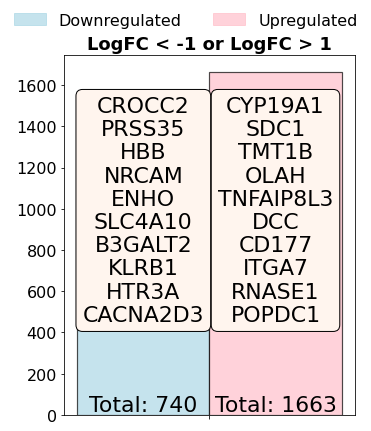

In [16]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')

def load_and_process_data():
    file_names = ['BH_Significant_GSE171110.csv']
    current_dir = os.getcwd()  

    for file_name in file_names:
        file_path = os.path.join(current_dir, file_name)

        if os.path.exists(file_path):
            print(f"Processing file: {file_name}")
            data = pd.read_csv(file_path)
            all_genes, significant_genes = analyze_gene_data(data)  

            new_base_name = file_name.replace('DE_', 'Ranked_DE_')

        else:
            print(f"File not found: {file_name}")


load_and_process_data()


# GSE189039

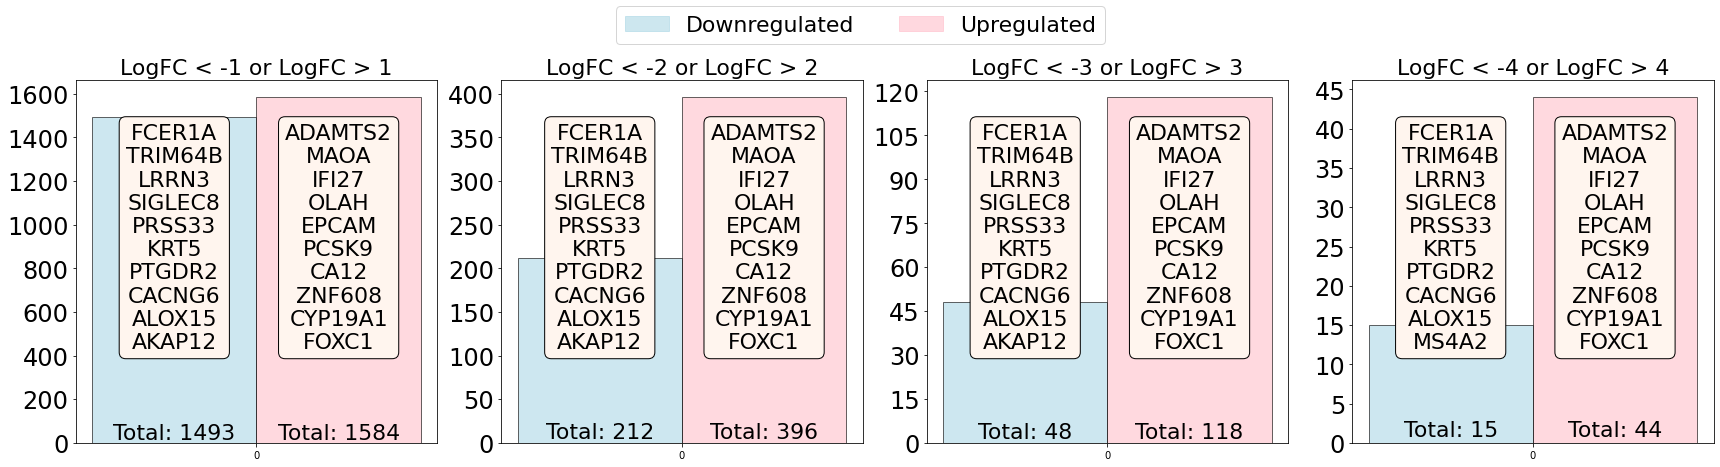

In [17]:
Data= dataframes['BH_Significant_GSE189039']

Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)


title = "BH_Significant_GSE189039"
config_Upset = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}



AllGenes_BH_Significant_GSE189039, Significant_BH_Significant_GSE189039 = volcano_plot_no_visualization(Data, M=config_Upset['Magnitude (M)'], A=config_Upset['Altitude (A)'],
                                     title=title, method=config_Upset['method'], alpha=config_Upset['alpha'],
                                     logFC_threshold=config_Upset['logFC_threshold'],
                                     highlight_genes=config_Upset['highlight_genes'], top_genes=config_Upset['top_genes'],
                                     upreg_criteria=config_Upset['upreg_criteria'],
                                     downreg_criteria=config_Upset['downreg_criteria'],
                                     upregulated_color=config_Upset['upregulated_color'],
                                     downregulated_color=config_Upset['downregulated_color'],
                                     not_significant_color=config_Upset['not_significant_color'],
                                     not_significant_between_logFC_threshold_color=config_Upset['not_significant_between_logFC_threshold_color'],
                                     pie_chart_size=config_Upset['pie_chart_size'],
                                     pie_chart_position=config_Upset['pie_chart_position'],
                                     ranking_method=config_Upset['ranking_method'],
                                     up_or_down_or_both=config_Upset['up_or_down_or_both'],
                                     g100=config_Upset['g100'], g010=config_Upset['g010'], g001=config_Upset['g001'],
                                     g110=config_Upset['g110'], g101=config_Upset['g101'], g011=config_Upset['g011'],
                                     g111=config_Upset['g111'])

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

logFC_threshold_values = range(1,5)  


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten() 

title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 24}
label_font = {'family': 'arial', 'color': 'navy', 'weight': 'bold', 'size': 24}
title_font2 = {'family': 'serif', 'color': 'black',  'size': 24}

for idx, logFC_threshold in enumerate(logFC_threshold_values):
    ax = axs[idx]
    config['logFC_threshold'] = logFC_threshold
    
    AllGenes, Significant = volcano_plot_no_visualization(Data, M=config['Magnitude (M)'], A=config['Altitude (A)'],
                                         title=title, method=config['method'], alpha=config['alpha'],
                                         logFC_threshold=config['logFC_threshold'],
                                         highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                         upreg_criteria=config['upreg_criteria'],
                                         downreg_criteria=config['downreg_criteria'],
                                         upregulated_color=config['upregulated_color'],
                                         downregulated_color=config['downregulated_color'],
                                         not_significant_color=config['not_significant_color'],
                                         not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                         pie_chart_size=config['pie_chart_size'],
                                         pie_chart_position=config['pie_chart_position'],
                                         ranking_method=config['ranking_method'],
                                         up_or_down_or_both=config['up_or_down_or_both'],
                                         g100=config['g100'], g010=config['g010'], g001=config['g001'],
                                         g110=config['g110'], g101=config['g101'], g011=config['g011'],
                                         g111=config['g111'])
    
    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]
    
    positions = np.arange(1)  
    width = 1

  
    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black',alpha=.6)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black',alpha=.6)
    if logFC_threshold == 0:
        title = f"LogFC < {logFC_threshold} or LogFC > {logFC_threshold}"
    else:
        title = f"LogFC < -{logFC_threshold} or LogFC > {logFC_threshold}"

    ax.set_title(title, fontsize=22)

    ax.set_xticks(positions)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=24) 
 

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }
    
    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist()

    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': Significant[Significant['Category'] == 'Upregulated'].shape[0],
            'Downregulated': Significant[Significant['Category'] =='Downregulated'].shape[0]
        }
    }

    upregulated_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    downregulated_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]  
    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, upregulated_counts, downregulated_counts, width)



upregulated_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.6)
downregulated_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.6)

fig.legend(handles=[downregulated_patch, upregulated_patch], loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.1), fontsize=22)

plt.tight_layout(rect=[0, 0, 1, .98])  

plt.show()




Processing file: BH_Significant_GSE189039.csv


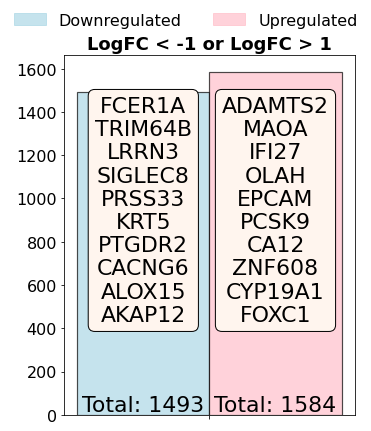

In [18]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')

def load_and_process_data():
    file_names = ['BH_Significant_GSE189039.csv']
    current_dir = os.getcwd()  

    for file_name in file_names:
        file_path = os.path.join(current_dir, file_name)

        if os.path.exists(file_path):
            print(f"Processing file: {file_name}")
            data = pd.read_csv(file_path)
            all_genes, significant_genes = analyze_gene_data(data)  

            new_base_name = file_name.replace('DE_', 'Ranked_DE_')

        else:
            print(f"File not found: {file_name}")


load_and_process_data()


# GSE201530

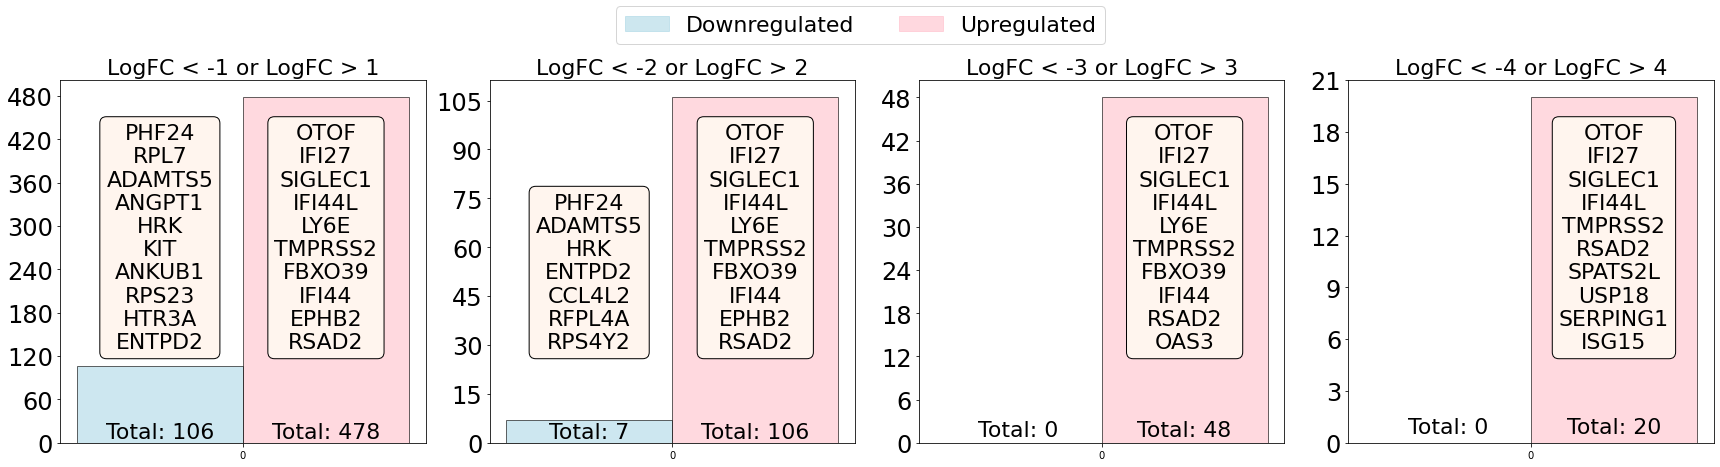

In [19]:
Data= dataframes['BH_Significant_GSE201530']

Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)


title = "BH_Significant_GSE201530"
config_Upset = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}



AllGenes_BH_Significant_GSE201530, Significant_BH_Significant_GSE201530 = volcano_plot_no_visualization(Data, M=config_Upset['Magnitude (M)'], A=config_Upset['Altitude (A)'],
                                     title=title, method=config_Upset['method'], alpha=config_Upset['alpha'],
                                     logFC_threshold=config_Upset['logFC_threshold'],
                                     highlight_genes=config_Upset['highlight_genes'], top_genes=config_Upset['top_genes'],
                                     upreg_criteria=config_Upset['upreg_criteria'],
                                     downreg_criteria=config_Upset['downreg_criteria'],
                                     upregulated_color=config_Upset['upregulated_color'],
                                     downregulated_color=config_Upset['downregulated_color'],
                                     not_significant_color=config_Upset['not_significant_color'],
                                     not_significant_between_logFC_threshold_color=config_Upset['not_significant_between_logFC_threshold_color'],
                                     pie_chart_size=config_Upset['pie_chart_size'],
                                     pie_chart_position=config_Upset['pie_chart_position'],
                                     ranking_method=config_Upset['ranking_method'],
                                     up_or_down_or_both=config_Upset['up_or_down_or_both'],
                                     g100=config_Upset['g100'], g010=config_Upset['g010'], g001=config_Upset['g001'],
                                     g110=config_Upset['g110'], g101=config_Upset['g101'], g011=config_Upset['g011'],
                                     g111=config_Upset['g111'])

config = {
    'method': 'BH',
    'alpha': 0.05,
    'logFC_threshold': 1,
     'up_or_down_or_both':'both_up_and_down_regulated',
    'highlight_genes': [],
    'top_genes': 20,
    'upreg_criteria': None,
    'downreg_criteria': None,
    'upregulated_color': '#FF0000',
    'downregulated_color': '#0000FF',
    'not_significant_color': '#808080',
    'not_significant_between_logFC_threshold_color': '#A0A0A0',
    'pie_chart_size': 0.2,
    'pie_chart_position': (0.85, 0.85),
    'ranking_method': 'MAS',
    'Magnitude (M)':1,
    'Altitude (A)':1,    
    'g100': (-1, 0.2),
    'g010': (1, 0.24),
    'g001': (-0.4, -0.5),
    'g110': (-0.6, 0.24),
    'g101': (-0.8, -0.3),
    'g011': (0.7, -0.1),
    'g111': (0.4, -0.6)
}

logFC_threshold_values = range(1,5)  


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten() 

title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 24}
label_font = {'family': 'arial', 'color': 'navy', 'weight': 'bold', 'size': 24}
title_font2 = {'family': 'serif', 'color': 'black',  'size': 24}

for idx, logFC_threshold in enumerate(logFC_threshold_values):
    ax = axs[idx]
    config['logFC_threshold'] = logFC_threshold
    
    AllGenes, Significant = volcano_plot_no_visualization(Data, M=config['Magnitude (M)'], A=config['Altitude (A)'],
                                         title=title, method=config['method'], alpha=config['alpha'],
                                         logFC_threshold=config['logFC_threshold'],
                                         highlight_genes=config['highlight_genes'], top_genes=config['top_genes'],
                                         upreg_criteria=config['upreg_criteria'],
                                         downreg_criteria=config['downreg_criteria'],
                                         upregulated_color=config['upregulated_color'],
                                         downregulated_color=config['downregulated_color'],
                                         not_significant_color=config['not_significant_color'],
                                         not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
                                         pie_chart_size=config['pie_chart_size'],
                                         pie_chart_position=config['pie_chart_position'],
                                         ranking_method=config['ranking_method'],
                                         up_or_down_or_both=config['up_or_down_or_both'],
                                         g100=config['g100'], g010=config['g010'], g001=config['g001'],
                                         g110=config['g110'], g101=config['g101'], g011=config['g011'],
                                         g111=config['g111'])
    
    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]
    
    positions = np.arange(1)  
    width = 1

  
    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black',alpha=.6)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black',alpha=.6)
    if logFC_threshold == 0:
        title = f"LogFC < {logFC_threshold} or LogFC > {logFC_threshold}"
    else:
        title = f"LogFC < -{logFC_threshold} or LogFC > {logFC_threshold}"

    ax.set_title(title, fontsize=22)

    ax.set_xticks(positions)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=24) 
 

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }
    
    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist()

    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': Significant[Significant['Category'] == 'Upregulated'].shape[0],
            'Downregulated': Significant[Significant['Category'] =='Downregulated'].shape[0]
        }
    }

    upregulated_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    downregulated_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]  # Keep as positive
    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, upregulated_counts, downregulated_counts, width)



upregulated_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.6)
downregulated_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.6)

fig.legend(handles=[downregulated_patch, upregulated_patch], loc='upper center', ncol=2, 
           bbox_to_anchor=(0.5, 1.1), fontsize=22)

plt.tight_layout(rect=[0, 0, 1, .98])  

plt.show()




Processing file: BH_Significant_GSE201530.csv


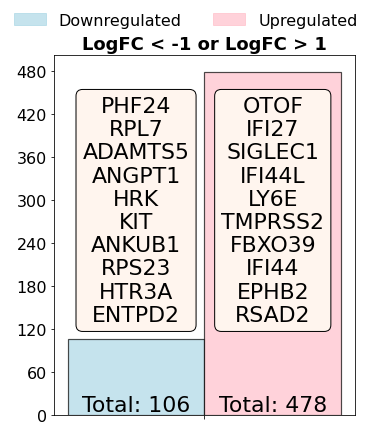

In [20]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')

def load_and_process_data():
    file_names = ['BH_Significant_GSE201530.csv']
    current_dir = os.getcwd()  

    for file_name in file_names:
        file_path = os.path.join(current_dir, file_name)

        if os.path.exists(file_path):
            print(f"Processing file: {file_name}")
            data = pd.read_csv(file_path)
            all_genes, significant_genes = analyze_gene_data(data)  

            new_base_name = file_name.replace('DE_', 'Ranked_DE_')

        else:
            print(f"File not found: {file_name}")


load_and_process_data()


In [21]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors


# files = {
#     'Original-ICU': 'BH_Significant_GSE157103_ICU.csv',
#     'Original-NonICU': 'BH_Significant_GSE157103_NonICU.csv',
#     'Beta': 'BH_Significant_GSE189039.csv',
#     'French': 'BH_Significant_GSE171110.csv',
#     'Omicron': 'BH_Significant_GSE201530.csv'
# }


# gene_sets = {
#     name: set(pd.read_csv(path)['Gene Symbol'].dropna())
#     for name, path in files.items()
# }

# overlap_counts = {}
# variants = list(gene_sets.keys())
# for i in range(len(variants)):
#     for j in range(i + 1, len(variants)):
#         v1, v2 = variants[i], variants[j]
#         intersection = gene_sets[v1].intersection(gene_sets[v2])
#         overlap_counts[(v1, v2)] = len(intersection)


# G = nx.Graph()
# for variant in gene_sets:
#     G.add_node(variant)

# for (v1, v2), weight in overlap_counts.items():
#     G.add_edge(v1, v2, weight=weight)


# pos = nx.circular_layout(G)


# weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
# norm = mcolors.Normalize(vmin=weights.min(), vmax=weights.max())
# edge_colors = cm.viridis(norm(weights))


# node_labels = {node: f"{node}\n(n={len(gene_sets[node])})" for node in G.nodes()}
# edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}


# plt.figure(figsize=(8, 8))
# nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='#A6CEE3', edgecolors='black')
# nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=14)
# nx.draw_networkx_edges(G, pos, width=12, edge_color=edge_colors)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20, font_color='black')

# plt.title('Circular Network of SARS-CoV-2 Variant Gene Overlaps', fontsize=16, weight='bold')
# plt.axis('off')
# plt.tight_layout()
# plt.show()


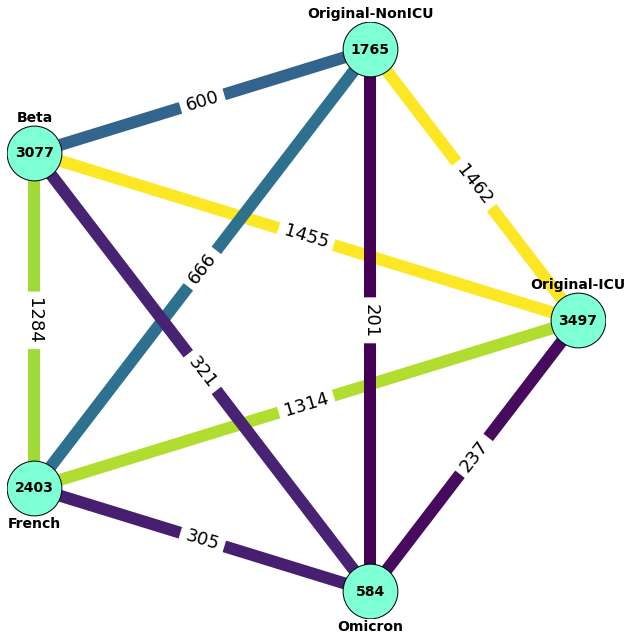

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors


files = {
    'Original-ICU': 'BH_Significant_GSE157103_ICU.csv',
    'Original-NonICU': 'BH_Significant_GSE157103_NonICU.csv',
    'Beta': 'BH_Significant_GSE189039.csv',
    'French': 'BH_Significant_GSE171110.csv',
    'Omicron': 'BH_Significant_GSE201530.csv'
}


gene_sets = {
    name: set(pd.read_csv(path)['Gene Symbol'].dropna())
    for name, path in files.items()
}


overlap_counts = {}
variants = list(gene_sets.keys())
for i in range(len(variants)):
    for j in range(i + 1, len(variants)):
        v1, v2 = variants[i], variants[j]
        intersection = gene_sets[v1].intersection(gene_sets[v2])
        overlap_counts[(v1, v2)] = len(intersection)


G = nx.Graph()
for variant in gene_sets:
    G.add_node(variant)

for (v1, v2), weight in overlap_counts.items():
    G.add_edge(v1, v2, weight=weight)


raw_pos = nx.circular_layout(G)
node_radius = 3.0
pos = {node: coords * node_radius for node, coords in raw_pos.items()}


weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
norm = mcolors.Normalize(vmin=weights.min(), vmax=weights.max())
edge_colors = cm.viridis(norm(weights))


edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}


plt.figure(figsize=(9, 9))
ax = plt.gca()


nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='aquamarine', edgecolors='black')
nx.draw_networkx_edges(G, pos, width=12, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, font_color='black')


for node, (x, y) in pos.items():
    plt.text(x, y, f"{len(gene_sets[node])}", ha='center', va='center', fontsize=14, fontweight='bold')


for node, (x, y) in pos.items():
    if y < -0.5:  
        plt.text(x, y - 0.3, node, ha='center', va='top', fontsize=14, fontweight='bold')
    else:  
        plt.text(x, y + 0.3, node, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

files = {
    'Original-ICU': 'BH_Significant_GSE157103_ICU.csv',
    'Original-NonICU': 'BH_Significant_GSE157103_NonICU.csv',
    'Beta': 'BH_Significant_GSE189039.csv',
    'French': 'BH_Significant_GSE171110.csv',
    'Omicron': 'BH_Significant_GSE201530.csv'
}

gene_sets = {
    name: set(pd.read_csv(path)['Gene Symbol'].dropna())
    for name, path in files.items()
}

print("Total Significant Genes per Variant:")
for name, genes in gene_sets.items():
    print(f"{name}: {len(genes)} genes")

overlap_data = []
variants = list(gene_sets.keys())
for i in range(len(variants)):
    for j in range(i + 1, len(variants)):
        v1, v2 = variants[i], variants[j]
        intersection = gene_sets[v1].intersection(gene_sets[v2])
        overlap_data.append({
            'Variant 1': v1,
            'Variant 2': v2,
            'Overlap Count': len(intersection)
        })

overlap_df = pd.DataFrame(overlap_data)

print("\nPairwise Overlap Counts Between Variants:")
print(overlap_df.to_string(index=False))


Total Significant Genes per Variant:
Original-ICU: 3497 genes
Original-NonICU: 1765 genes
Beta: 3077 genes
French: 2403 genes
Omicron: 584 genes

Pairwise Overlap Counts Between Variants:
       Variant 1        Variant 2  Overlap Count
    Original-ICU  Original-NonICU           1462
    Original-ICU             Beta           1455
    Original-ICU           French           1314
    Original-ICU          Omicron            237
 Original-NonICU             Beta            600
 Original-NonICU           French            666
 Original-NonICU          Omicron            201
            Beta           French           1284
            Beta          Omicron            321
          French          Omicron            305


In [24]:
def analyze_gene_data(Data):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.ticker import MaxNLocator

    Data.rename(columns={'GeneSymbol': 'Gene Symbol'}, inplace=True)

    title = 'Ranked Genes'
    config = {
        'method': 'BH',
        'alpha': 0.05,
        'logFC_threshold': 1,
        'up_or_down_or_both': 'both_up_and_down_regulated',
        'highlight_genes': [],
        'top_genes': 20,
        'upreg_criteria': None,
        'downreg_criteria': None,
        'upregulated_color': '#FF0000',
        'downregulated_color': '#0000FF',
        'not_significant_color': '#808080',
        'not_significant_between_logFC_threshold_color': '#A0A0A0',
        'pie_chart_size': 0.2,
        'pie_chart_position': (0.85, 0.85),
        'ranking_method': 'MAS',
        'Magnitude (M)': 1,
        'Altitude (A)': 1,
        'g100': (-1, 0.2),
        'g010': (1, 0.24),
        'g001': (-0.4, -0.5),
        'g110': (-0.6, 0.24),
        'g101': (-0.8, -0.3),
        'g011': (0.7, -0.1),
        'g111': (0.4, -0.6)
    }

    AllGenes, Significant = volcano_plot_no_visualization(
        Data,
        M=config['Magnitude (M)'],
        A=config['Altitude (A)'],
        title=title,
        method=config['method'],
        alpha=config['alpha'],
        logFC_threshold=config['logFC_threshold'],
        highlight_genes=config['highlight_genes'],
        top_genes=config['top_genes'],
        upreg_criteria=config['upreg_criteria'],
        downreg_criteria=config['downreg_criteria'],
        upregulated_color=config['upregulated_color'],
        downregulated_color=config['downregulated_color'],
        not_significant_color=config['not_significant_color'],
        not_significant_between_logFC_threshold_color=config['not_significant_between_logFC_threshold_color'],
        pie_chart_size=config['pie_chart_size'],
        pie_chart_position=config['pie_chart_position'],
        ranking_method=config['ranking_method'],
        up_or_down_or_both=config['up_or_down_or_both'],
        g100=config['g100'], g010=config['g010'], g001=config['g001'],
        g110=config['g110'], g101=config['g101'], g011=config['g011'],
        g111=config['g111']
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 6))  

    upregulated_counts = Significant[Significant['Category'] == 'Upregulated'].shape[0]
    downregulated_counts = Significant[Significant['Category'] == 'Downregulated'].shape[0]

    positions = np.arange(1)
    width = 0.6

    ax.bar(positions - width/2, downregulated_counts, width, label='Downregulated', color='lightblue', edgecolor='black', alpha=0.7, linewidth=1.2)
    ax.bar(positions + width/2, upregulated_counts, width, label='Upregulated', color='pink', edgecolor='black', alpha=0.7, linewidth=1.2)

    ax.set_title("LogFC < -1 or LogFC > 1", fontsize=18, weight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels([], fontsize=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=16)

    top_10_down_genes = {
        'BH': Significant[Significant['logFC'] < 0].head(10)['Gene Symbol'].tolist(),
    }

    top_10_up_genes = {
        'BH': Significant[Significant['logFC'] > 0].head(10)['Gene Symbol'].tolist(),
    }

    summary_stats = {
        'BH': {
            'Total': Significant.shape[0],
            'Upregulated': upregulated_counts,
            'Downregulated': downregulated_counts
        }
    }

    up_counts = [summary_stats[obj]['Upregulated'] for obj in summary_stats]
    down_counts = [summary_stats[obj]['Downregulated'] for obj in summary_stats]

    annotate_bars_vertical_with_totals(ax, positions, top_10_down_genes, top_10_up_genes, up_counts, down_counts, width)

    up_patch = mpatches.Patch(color='pink', label='Upregulated', edgecolor='black', alpha=0.7)
    down_patch = mpatches.Patch(color='lightblue', label='Downregulated', edgecolor='black', alpha=0.7)

    fig.legend(handles=[down_patch, up_patch], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.01), fontsize=16, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, .95])
    plt.show()

    return AllGenes, Significant


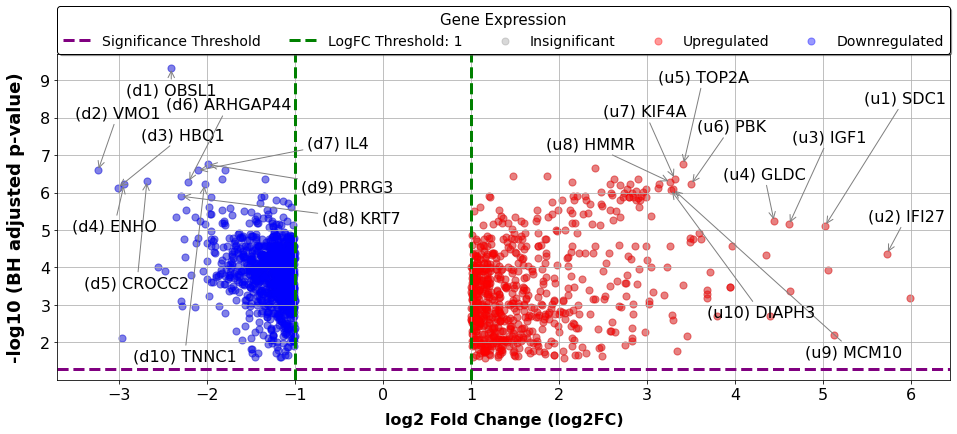

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

def create_volcano_plot(dataframe, conditionA, conditionB, Magnitude, Altitude, use_bh_adjusted_pvalue=True, logfc_threshold=0, top=10, top_annotation=20):
    DDAATTAA = dataframe.copy()

    DDAATTAA['Gene'] = DDAATTAA['Gene Symbol']
    DDAATTAA['Log2FC'] = DDAATTAA['logFC']
    
    if use_bh_adjusted_pvalue:
        if 'FDR' not in DDAATTAA.columns:
            DDAATTAA['FDR'] = multipletests(DDAATTAA['PValue'], method='fdr_bh')[1]
        DDAATTAA['p_value_used'] = DDAATTAA['FDR']
    else:
        DDAATTAA['p_value_used'] = DDAATTAA['PValue']
    
    DDAATTAA['neg_log_pval'] = -np.log10(DDAATTAA['p_value_used'])
    
    DDAATTAA['MAS_Score'] = np.where(DDAATTAA['p_value_used'] < 0.05, 
                                     np.abs((DDAATTAA['Log2FC'])**Magnitude) * (np.abs(np.log10(DDAATTAA['p_value_used']))**Altitude), 
                                     np.nan)
    
    DDAATTAA = DDAATTAA.sort_values(by='MAS_Score', ascending=False)
    DDAATTAA.reset_index(drop=True, inplace=True)
    DDAATTAA['MAS Rank'] = DDAATTAA.index + 1
    
    significant_genes = DDAATTAA[DDAATTAA['Log2FC'].abs() >= logfc_threshold]
    nonsignificant_genes = DDAATTAA[DDAATTAA['Log2FC'].abs() < logfc_threshold]
    
    top_genes = DDAATTAA.loc[DDAATTAA['MAS Rank'].between(1, top), 'Gene']
    top_R_values = DDAATTAA.loc[DDAATTAA['MAS Rank'].between(1, top), 'MAS Rank']
    top_Log2FC_values = DDAATTAA.loc[DDAATTAA['MAS Rank'].between(1, top), 'Log2FC']
    top_pval_values = DDAATTAA.loc[DDAATTAA['MAS Rank'].between(1, top), 'p_value_used']
    top_MAS_scores = DDAATTAA.loc[DDAATTAA['MAS Rank'].between(1, top), 'MAS_Score']
    
    significant_genes_upregulated = (significant_genes['neg_log_pval'] >= -np.log10(0.05)) & (significant_genes['Log2FC'] > 0)
    significant_genes_downregulated = (significant_genes['neg_log_pval'] >= -np.log10(0.05)) & (significant_genes['Log2FC'] < 0)

    DDAATTAA['Regulation'] = 'Insignificant'
    DDAATTAA.loc[(DDAATTAA['Log2FC'] < 0) & (DDAATTAA['Log2FC'].abs() >= logfc_threshold), 'Regulation'] = 'Downregulated'
    DDAATTAA.loc[(DDAATTAA['Log2FC'] > 0) & (DDAATTAA['Log2FC'].abs() >= logfc_threshold), 'Regulation'] = 'Upregulated'

    plt.figure(figsize=(16, 6))
    plt.scatter(DDAATTAA['Log2FC'], DDAATTAA['neg_log_pval'], color='gray', alpha=0.3, s=50, label='Insignificant')
    
    
    
    
    mask_upregulated = (significant_genes['neg_log_pval'] >= -np.log10(0.05)) & (significant_genes['Log2FC'] > 0)
    mask_downregulated = (significant_genes['neg_log_pval'] >= -np.log10(0.05)) & (significant_genes['Log2FC'] < 0)

    significant_genes_upregulated_data = significant_genes[mask_upregulated]
    significant_genes_downregulated_data  = significant_genes[mask_downregulated]



    plt.scatter(significant_genes.loc[significant_genes_upregulated, 'Log2FC'], significant_genes.loc[significant_genes_upregulated, 'neg_log_pval'], color=Hue[conditionB], alpha=0.4, s=50, label='Upregulated')

    plt.scatter(significant_genes.loc[significant_genes_downregulated, 'Log2FC'], significant_genes.loc[significant_genes_downregulated, 'neg_log_pval'], color=Hue[conditionA], alpha=0.4, s=50, label='Downregulated')

    upregulated_styles = [
        ((80, 120), "arc3,rad=.7"),
        ((20, 30), "arc3,rad=.5"),
        ((40, 80), "arc3,rad=-.3"),
        ((-10, 40), "arc3,rad=-.4"),
        ((20, 80), "arc3,rad=0"),
        ((40, 50), "arc3,rad=.1"),
        ((-30, 60), "arc3,rad=.6"),
        ((-80, 30), "arc3,rad=-.6"),
        ((180, -170), "arc3,rad=.3"),
        ((90, -130), "arc3,rad=.5"),
    ]

    downregulated_styles = [
        ((0, -30), "arc3,rad=.7"),
        ((20, 50), "arc3,rad=.5"),
        ((65, 45), "arc3,rad=-.3"),
        ((-10, -50), "arc3,rad=-.4"),
        ((-10, -110), "arc3,rad=0"),
        ((40, 70), "arc3,rad=.1"),
        ((140, 20), "arc3,rad=.6"),
        ((180, -30), "arc3,rad=-.6"),
        ((140, -30), "arc3,rad=.3"),
        ((-20, -180), "arc3,rad=.5"),
    ]

    counter_up = 0
    counter_down = 0
    
    top_up_genes = significant_genes[(significant_genes['Log2FC'] > 0)].nsmallest(10, 'MAS Rank')
    top_down_genes = significant_genes[(significant_genes['Log2FC'] < 0)].nsmallest(10, 'MAS Rank')

    for idx, (i, row) in enumerate(top_up_genes.iterrows(), start=1):
        annotation_text = f"(u{idx}) {row['Gene']}"
        annotation_color = Hue[conditionB]
        offset, rad = upregulated_styles[counter_up % len(upregulated_styles)]
        counter_up += 1
        plt.annotate(annotation_text, (row['Log2FC'], row['neg_log_pval']),
                     fontsize=16, ha='center', va='bottom',
                     textcoords='offset points', xytext=offset,
                     arrowprops=dict(arrowstyle="->", color='gray'))

    for idx, (i, row) in enumerate(top_down_genes.iterrows(), start=1):
        annotation_text = f"(d{idx}) {row['Gene']}"
        annotation_color = Hue[conditionA]
        offset, rad = downregulated_styles[counter_down % len(downregulated_styles)]
        counter_down += 1
        plt.annotate(annotation_text, (row['Log2FC'], row['neg_log_pval']),
                     fontsize=16, ha='center', va='bottom',
                     textcoords='offset points', xytext=offset,
                     arrowprops=dict(arrowstyle="->", color='gray'))



    plt.axhline(y=-np.log10(0.05), color='purple', linestyle='--', linewidth=3, label='Significance Threshold')
    
    plt.axvline(x=logfc_threshold, color='green', linestyle='--',linewidth=3, label=f'LogFC Threshold: {logfc_threshold}')
    plt.axvline(x=-logfc_threshold, color='green', linestyle='--',linewidth=3)

    plt.xlabel('log2 Fold Change (log2FC)', fontsize=16, fontweight='bold', labelpad=10)

    plt.ylabel('-log10 (BH adjusted p-value)', fontsize=18, fontweight='bold', labelpad=15)


    plt.grid(True, linestyle='-', alpha=2)
    legend_position = (0, 1)  # Adjust x and y to position the legend

    legend = plt.legend(frameon=True, framealpha=1, ncol=5, edgecolor='black', facecolor='white', shadow=True, loc=legend_position, fontsize=14, title='Gene Expression', title_fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=16)
    from matplotlib.ticker import MultipleLocator
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))


    legend.get_frame().set_linewidth(1) 
    plt.ylim(bottom=-np.log10(0.05)-.3)

    plt.show()
    
    return  significant_genes_upregulated_data,  significant_genes_downregulated_data ,significant_genes

Hue = {
    'Mock': 'blue', 'Original-ICU': 'red'
}

DDAATTAA = pd.read_csv('BH_Significant_GSE157103_NonICU.csv', encoding='unicode_escape')

significant_genes_upregulated_data,  significant_genes_downregulated_data, Significant_v2 = create_volcano_plot(DDAATTAA, 'Mock', 'Original-ICU', Magnitude=1, Altitude=1, use_bh_adjusted_pvalue=True, logfc_threshold=1, top=10, top_annotation=10)



# Overal

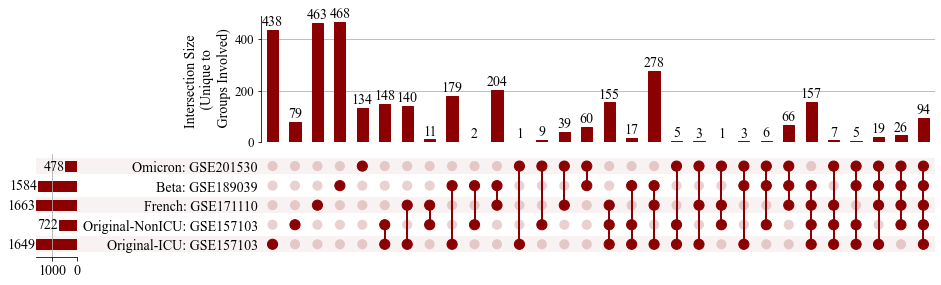

In [26]:
import pandas as pd
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

data = {
    'Original-ICU: GSE157103': set(BH_Upregulated_GSE157103_ICU['Gene Symbol']),    
    'Original-NonICU: GSE157103': set(BH_Upregulated_GSE157103_NonICU['Gene Symbol']),
    
    'French: GSE171110': set(BH_Upregulated_GSE171110['Gene Symbol']),
    'Beta: GSE189039': set(BH_Upregulated_GSE189039['Gene Symbol']),
   'Omicron: GSE201530': set(BH_Upregulated_GSE201530['Gene Symbol']),

  
}

combined = from_contents(data)


plt.rcParams.update({
    'font.size': 14,             # Font size
    'font.family': 'Times New Roman',      # Use a serif font family for a fancier look
    'font.weight': 'normal',       # Make the font bold
    'font.style': 'normal'       # Ensure the font style is set to normal (not italic)
})

from upsetplot import UpSet

upset = UpSet(combined, 
              subset_size='count', 
              element_size=29, 
              show_counts=True, 
              sort_categories_by=None, 
              facecolor='darkred')  # Sets the bar color to dark red

upset.plot()


plt.setp(plt.gca().get_yticklabels(), fontsize=13, fontweight='normal', family='Times New Roman')
plt.gca().set_ylabel('Intersection Size \n (Unique to \n Groups Involved)', fontsize=14, fontweight='normal', family='Times New Roman')


plt.show()


In [27]:
import pandas as pd
from itertools import combinations

def get_top_genes_by_mas_rank(dataframes, group_names):
    """
    This function finds the top 10 genes for all unique and common gene sets based on the minimum of the maximum MAS Rank.
    
    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes containing gene data.
    - group_names (list of str): List of names for each group.
    
    Returns:
    - dict: A dictionary containing top 10 genes for each combination.
    """
    gene_sets = {name: set(df['Gene Symbol'].dropna().unique()) for name, df in zip(group_names, dataframes)}
    
    top_genes_results = {}

    def find_top_genes(df, genes):
        gene_rank_max = df[df['Gene Symbol'].isin(genes)].groupby('Gene Symbol')['MAS_rank'].max().reset_index()
        top_10_genes = gene_rank_max.nsmallest(100, 'MAS_rank')['Gene Symbol'].tolist()
        return top_10_genes

    for r in range(1, len(group_names) + 1):
        for combo in combinations(group_names, r):
            combo_name = ', '.join(combo)
            common_genes = set.intersection(*(gene_sets[group] for group in combo))
            other_groups = set(group_names).difference(combo)
            other_genes = set.union(*(gene_sets[group] for group in other_groups)) if other_groups else set()
            uniquely_common_genes = common_genes.difference(other_genes)

            if uniquely_common_genes:
                combined_df = pd.concat([dataframes[group_names.index(group)] for group in combo], ignore_index=True)
                top_genes = find_top_genes(combined_df, uniquely_common_genes)
                top_genes_results[combo_name] = top_genes

    return top_genes_results


dfs = [
    BH_Upregulated_GSE157103_ICU  , 
   BH_Upregulated_GSE157103_NonICU,    
    BH_Upregulated_GSE171110,
    BH_Upregulated_GSE189039,
    BH_Upregulated_GSE201530,
]

group_names = [

    'Original-ICU: GSE157103',    
    'Original-NonICU: GSE157103',
    
    'French: GSE171110',
    'Beta: GSE189039',
   'Omicron: GSE201530',

]

top_genes_results_Up = get_top_genes_by_mas_rank(dfs, group_names)

for combo, top_genes in top_genes_results_Up.items():
    print(f"\nTop 10 genes for combination {combo}:")
    print(top_genes)



Top 10 genes for combination Original-ICU: GSE157103:
['IL1RL2', 'SLC38A2', 'RBM11', 'LYG2', 'AREG', 'TMEM169', 'LCE5A', 'SLC44A1', 'GYPB', 'PAG1', 'TAFA2', 'GNA14', 'TNPO3', 'MCU', 'DEFA5', 'FOXN2', 'GCLM', 'TMX4', 'SNTB2', 'PIP4P2', 'TFDP1', 'ARK2N', 'IPO11', 'ATP11B', 'PDZD8', 'FBXW2', 'TTPAL', 'EMB', 'BLM', 'CDKL3', 'APP', 'CDK2', 'SSH1', 'PRG3', 'KCNB1', 'OSBPL9', 'PLD1', 'USP6NL', 'KLF7', 'CPNE3', 'RAB3IL1', 'SLC40A1', 'GBE1', 'WDR47', 'CAB39', 'PKP2', 'KDM7A', 'CLASP1', 'NEK7', 'PRKAA1', 'HIPK1', 'PIK3CB', 'CDO1', 'NUP58', 'ANKRD28', 'RACGAP1', 'TAF8', 'PBLD', 'AICDA', 'KBTBD7', 'KLHL24', 'NUCB2', 'CPD', 'C7orf25', 'SYNE1', 'LONP2', 'ROCK1', 'ANKS1A', 'WIPI1', 'USP6', 'LEPROT', 'ARL6IP6', 'TANK', 'RFX3', 'CFAP206', 'TYW5', 'ZNF367', 'LCOR', 'CYP26A1', 'CDCA7L', 'SWT1', 'NEBL', 'SPOPL', 'MATN2', 'GRIP2', 'RASSF2', 'SLF1', 'TESMIN', 'BMAL1', 'GFI1', 'MREG', 'GTF2H2C', 'C11orf42', 'SLC49A4', 'GCNT1', 'RPS6KA3', 'STAU2', 'SLC25A40', 'MAP3K2', 'TLR8']

Top 10 genes for combination O

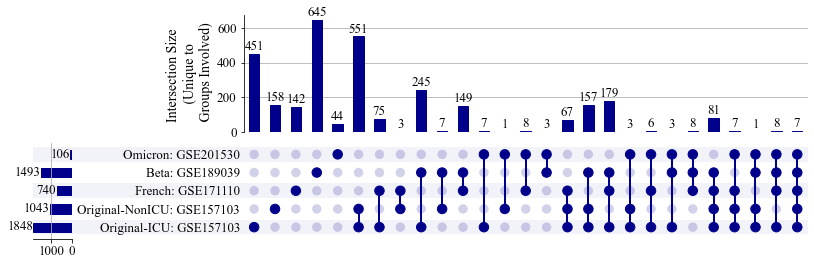

In [28]:
import pandas as pd
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

data = {
    'Original-ICU: GSE157103': set(BH_Downregulated_GSE157103_ICU['Gene Symbol']),    
    'Original-NonICU: GSE157103': set(BH_Downregulated_GSE157103_NonICU['Gene Symbol']),
    'French: GSE171110': set(BH_Downregulated_GSE171110['Gene Symbol']),
    'Beta: GSE189039': set(BH_Downregulated_GSE189039['Gene Symbol']),
   'Omicron: GSE201530': set(BH_Downregulated_GSE201530['Gene Symbol']),

  
}

combined = from_contents(data)


plt.rcParams.update({
    'font.size': 13,             # Font size
    'font.family': 'Times New Roman',      # Use a serif font family for a fancier look
    'font.weight': 'normal',       # Make the font bold
    'font.style': 'normal'       # Ensure the font style is set to normal (not italic)
})

from upsetplot import UpSet

upset = UpSet(combined, 
              subset_size='count', 
              element_size=27, 
              show_counts=True, 
              sort_categories_by=None, 
              facecolor='darkblue')  

upset.plot()


plt.setp(plt.gca().get_yticklabels(), fontsize=13, fontweight='normal', family='Times New Roman')
plt.gca().set_ylabel('Intersection Size \n (Unique to \n Groups Involved)', fontsize=14, fontweight='normal', family='Times New Roman')


# Show the plot
plt.show()


In [29]:
import pandas as pd
from itertools import combinations

def get_top_genes_by_mas_rank(dataframes, group_names):
    """
    This function finds the top 10 genes for all unique and common gene sets based on the minimum of the maximum MAS Rank.
    
    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes containing gene data.
    - group_names (list of str): List of names for each group.
    
    Returns:
    - dict: A dictionary containing top 10 genes for each combination.
    """
    gene_sets = {name: set(df['Gene Symbol'].dropna().unique()) for name, df in zip(group_names, dataframes)}
    
    top_genes_results = {}

    def find_top_genes(df, genes):
        gene_rank_max = df[df['Gene Symbol'].isin(genes)].groupby('Gene Symbol')['MAS_rank'].max().reset_index()
        top_10_genes = gene_rank_max.nsmallest(30, 'MAS_rank')['Gene Symbol'].tolist()
        return top_10_genes

    for r in range(1, len(group_names) + 1):
        for combo in combinations(group_names, r):
            combo_name = ', '.join(combo)
            common_genes = set.intersection(*(gene_sets[group] for group in combo))
            other_groups = set(group_names).difference(combo)
            other_genes = set.union(*(gene_sets[group] for group in other_groups)) if other_groups else set()
            uniquely_common_genes = common_genes.difference(other_genes)

            if uniquely_common_genes:
                combined_df = pd.concat([dataframes[group_names.index(group)] for group in combo], ignore_index=True)
                top_genes = find_top_genes(combined_df, uniquely_common_genes)
                top_genes_results[combo_name] = top_genes

    return top_genes_results


dfs = [
    BH_Downregulated_GSE157103_ICU  , 
   BH_Downregulated_GSE157103_NonICU,    
    BH_Downregulated_GSE171110,
    BH_Downregulated_GSE189039,
    BH_Downregulated_GSE201530,
]

group_names = [

    'Original-ICU: GSE157103',    
    'Original-NonICU: GSE157103',
    'French: GSE171110',
    'Beta: GSE189039',
   'Omicron: GSE201530',

]

top_genes_results_Down= get_top_genes_by_mas_rank(dfs, group_names)

for combo, top_genes in top_genes_results_Down.items():
    print(f"\nTop 10 genes for combination {combo}:")
    print(top_genes)




Top 10 genes for combination Original-ICU: GSE157103:
['TNFRSF18', 'ITIH1', 'IL18BP', 'SEPTIN9', 'NAPSA', 'CPNE7', 'ARHGEF10L', 'P2RY6', 'PGAP3', 'S1PR2', 'PIK3R6', 'IL9R', 'AXL', 'TRPM4', 'BICDL1', 'PVRIG', 'DNPEP', 'HLA-DMA', 'FOXP4', 'GNGT2', 'GALNT6', 'NBDY', 'LOC107986860', 'ENTPD6', 'C10orf143', 'SERGEF', 'PSMG4', 'CIROZ', 'PCED1A', 'IGSF3']

Top 10 genes for combination Original-NonICU: GSE157103:
['KRT7', 'EBI3', 'ZNF865', 'SLC15A3', 'JUNB', 'GSTZ1', 'ND3', 'ROGDI', 'PPP2R3B', 'METRNL', 'TWF2', 'TSPO', 'AKT1S1', 'LRRC61', 'AGPAT2', 'BORCS8', 'GPR137', 'WDR13', 'MMP24OS', 'CFP', 'ZNF784', 'SERF2', 'FIS1', 'KCNG2', 'EGLN2', 'SH3BGRL3', 'RAB4B', 'VENTX', 'PTGES', 'PYCARD']

Top 10 genes for combination French: GSE171110:
['PRSS35', 'HBB', 'HBD', 'GFPT2', 'CTTNBP2', 'EHF', 'COL26A1', 'NAT8L', 'COL5A1', 'CXCR6', 'RPL17', 'TPT1', 'RPS13', 'CACNB4', 'RPS7', 'RNF17', 'RPL15', 'ADAT2', 'OVGP1', 'FAM110C', 'COQ10A', 'NUDT11', 'TENM4', 'CFAP36', 'CSMD1', 'CLIC6', 'ZNF577', 'PROCR', 'OTUD

In [30]:
Significant_BH_Significant_GSE157103_NonICU.to_csv('BH_Mock_vs_GSE157103NonICU.csv', index=False)
Significant_BH_Significant_GSE157103_ICU.to_csv('BH_Mock_vs_GSE157103ICU.csv', index=False)
Significant_BH_Significant_GSE171110.to_csv('BH_Mock_vs_GSE171110.csv', index=False)
Significant_BH_Significant_GSE189039.to_csv('BH_Mock_vs_GSE189039.csv', index=False)
Significant_BH_Significant_GSE201530.to_csv('BH_Mock_vs_GSE201530.csv', index=False)

# train and test performance 

In [31]:
n=30
concatenated_list = (
 
    top_genes_results_Up['Original-ICU: GSE157103, Original-NonICU: GSE157103, French: GSE171110, Beta: GSE189039, Omicron: GSE201530'][:n]
    +
    top_genes_results_Down['Original-ICU: GSE157103, Original-NonICU: GSE157103, French: GSE171110, Beta: GSE189039, Omicron: GSE201530'][:n]
    

)

In [32]:
concatenated_list

['RRM2',
 'HJURP',
 'CDC45',
 'CDC25A',
 'E2F8',
 'BIRC5',
 'CKAP2L',
 'CDCA2',
 'SPC25',
 'DLGAP5',
 'ANLN',
 'KIF4A',
 'KIF14',
 'SLC1A3',
 'KIF18B',
 'IFI27',
 'CDCA5',
 'CLSPN',
 'MELK',
 'DIAPH3',
 'CENPA',
 'BUB1',
 'CCNA1',
 'CDC20',
 'CEP55',
 'NEK2',
 'ESPL1',
 'TCN1',
 'SKA1',
 'TARM1',
 'CACNG6',
 'RPL3',
 'RPS17',
 'RPS23',
 'PMP22',
 'CACNG8',
 'KLRB1']

# Training 

# GSE157103

In [33]:

ALL = pd.read_csv('GSE157103-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

HLTY = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
NonICU = dddata[[col for col in dddata.columns if col.startswith('COVID-19')]]
ICU = dddata[[col for col in dddata.columns if col.startswith('Original strain ICU- USA -2020')]]


In [34]:
NonICU

,COVID-19 (1),COVID-19 (2),COVID-19 (3),COVID-19 (4),COVID-19 (5),COVID-19 (6),COVID-19 (7),COVID-19 (8),COVID-19 (9),COVID-19 (10),...,COVID-19 (41),COVID-19 (42),COVID-19 (43),COVID-19 (44),COVID-19 (45),COVID-19 (46),COVID-19 (47),COVID-19 (48),COVID-19 (49),COVID-19 (50)
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC112268260,65,35,125,75,243,43,46,33,45,34,...,93,45,63,44,99,40,42,78,158,133
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOC105378947,3,4,7,7,19,3,4,3,8,4,...,5,2,5,4,7,1,3,5,17,10
OR4F16,10,7,19,9,59,13,7,7,10,12,...,54,4,6,3,22,0,2,5,77,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND4L,12250,9665,4030,18745,10515,11595,14496,17040,12915,19001,...,13868,8870,7953,6435,7834,5827,3108,2585,8525,5017
ND4,74728,80010,44163,140818,78660,124308,119453,120814,116219,148896,...,95335,96923,130387,145148,65293,72855,80027,81688,63854,58978
ND5,37774,37716,16412,80051,26916,56378,50230,64758,40318,64708,...,33559,38186,33711,32771,25498,30044,18649,18722,22994,14446


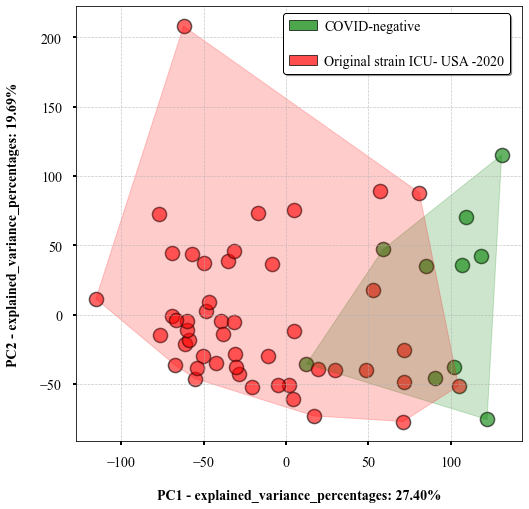

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

color_map = {
    'COVID-negative': 'green',     
    'COVID-19': 'orange',    
    'Original strain ICU- USA -2020': 'red',        

}

data=pd.concat([HLTY,ICU],axis=1)
data_transposed = data.transpose()

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(.45, 1.), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


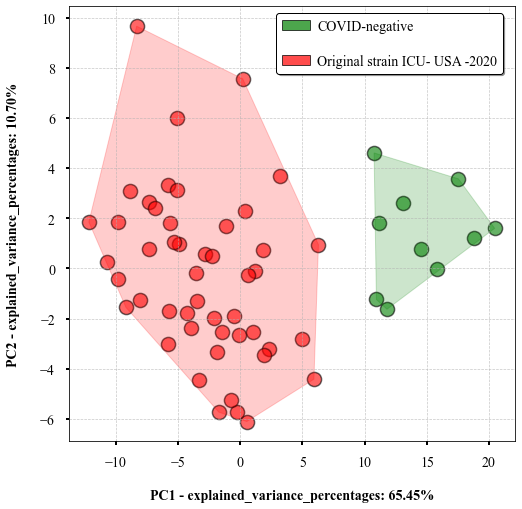

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data=pd.concat([HLTY,ICU],axis=1)

data_transposed = data.transpose()[concatenated_list]
# Standardize the data
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(.45, 1.), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


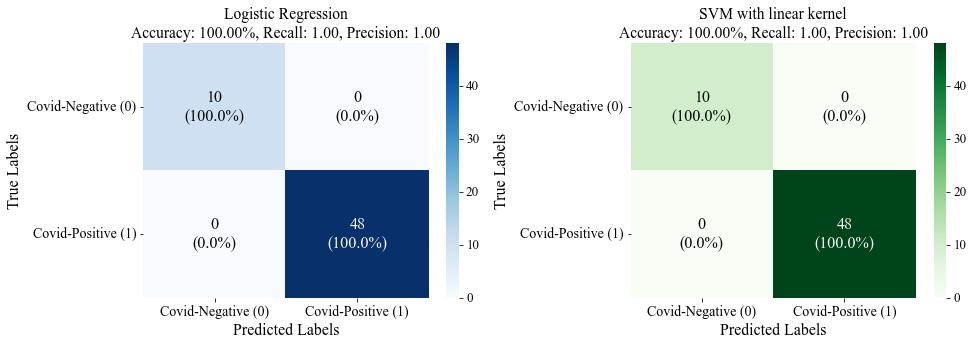

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

conf_matrix_log_GSE157103_ICU =conf_matrix_log
accuracy_log_GSE157103_ICU = accuracy_log
recall_log_GSE157103_ICU = recall_log
precision_log_GSE157103_ICU = precision_log
conf_matrix_svm_GSE157103_ICU =conf_matrix_svm
accuracy_svm_GSE157103_ICU = accuracy_svm
recall_svm_GSE157103_ICU = recall_svm
precision_svm_GSE157103_ICU = precision_svm


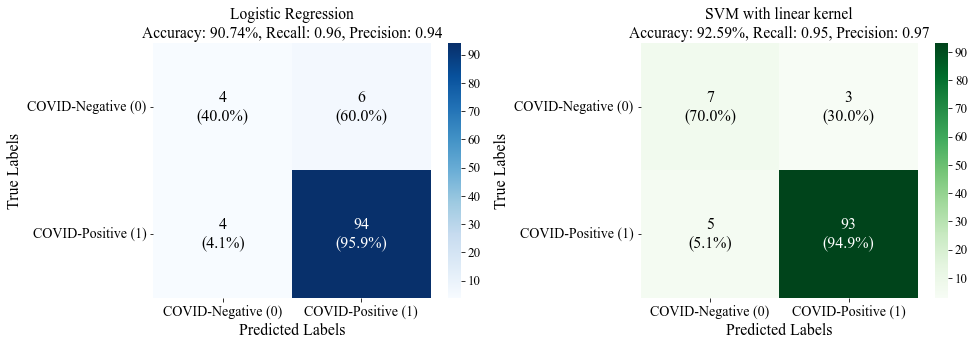

In [38]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

ALL = pd.read_csv('GSE157103-Ready.csv')

dddata = ALL.set_index('Gene Symbol')

HLTY = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
NonICU = dddata[[col for col in dddata.columns if col.startswith('COVID-19')]]
ICU = dddata[[col for col in dddata.columns if col.startswith('Original strain ICU- USA -2020')]]

COVID_positive = pd.concat([NonICU, ICU], axis=1)

COVID_positive.columns = ['COVID-positive' for _ in COVID_positive.columns]
HLTY.columns = ['COVID-negative' for _ in HLTY.columns]

combined_data = pd.concat([HLTY, COVID_positive], axis=1)

X = combined_data.T[concatenated_list]   
y = [0 if 'negative' in col else 1 for col in X.index]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

log_reg = LogisticRegression()
log_reg.fit(X_pca, y)
y_pred_log = log_reg.predict(X_pca)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_pca, y)
y_pred_svm = svm.predict(X_pca)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['COVID-Negative (0)', 'COVID-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['COVID-Negative (0)', 'COVID-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_svm*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['COVID-Negative (0)', 'COVID-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['COVID-Negative (0)', 'COVID-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()


conf_matrix_log_GSE157103 = conf_matrix_log
accuracy_log_GSE157103 = accuracy_log
recall_log_GSE157103 = recall_log
precision_log_GSE157103 = precision_log
conf_matrix_svm_GSE157103 = conf_matrix_svm
accuracy_svm_GSE157103 = accuracy_svm
recall_svm_GSE157103 = recall_svm
precision_svm_GSE157103 = precision_svm






# GSE171110

In [39]:

ALL = pd.read_csv('GSE171110-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('French strain-France-2020')]]

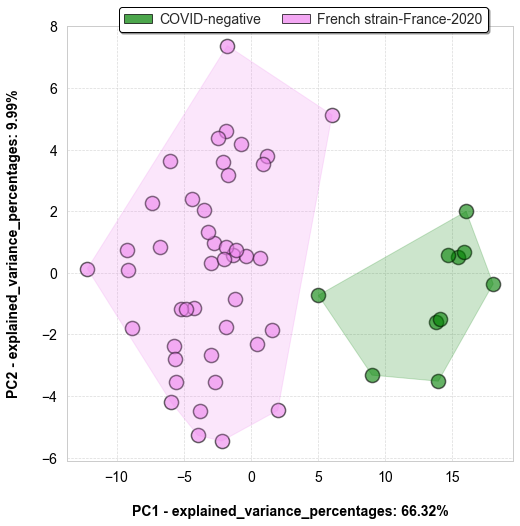

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data=pd.concat([Healthy,SARS_CoV_2],axis=1)
color_map = {
    'COVID-negative': 'green',     
    'French strain-France-2020': 'violet',        

}
data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.1, 1.06), ncol=5, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


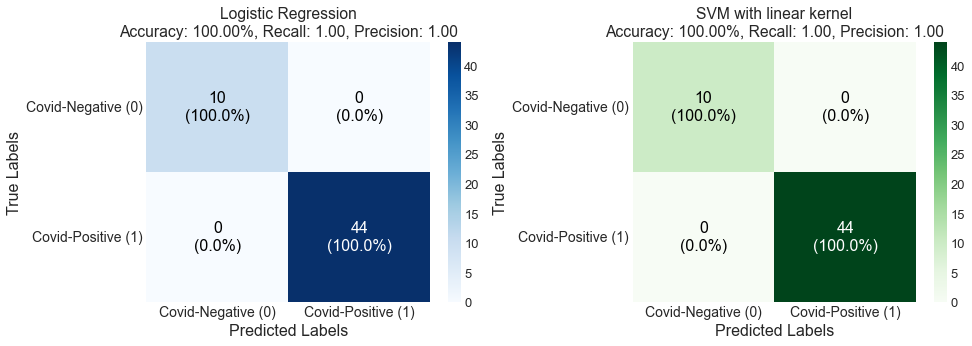

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

conf_matrix_log_GSE171110 =conf_matrix_log
accuracy_log_GSE171110 = accuracy_log
recall_log_GSE171110 = recall_log
precision_log_GSE171110 = precision_log
conf_matrix_svm_GSE171110 =conf_matrix_svm
accuracy_svm_GSE171110 = accuracy_svm
recall_svm_GSE171110 = recall_svm
precision_svm_GSE171110 = precision_svm


# GSE189039

In [42]:

ALL = pd.read_csv('GSE189039-Ready.csv')



dddata = ALL.set_index('Gene Symbol')
Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('Beta strain- Italy and  Austria -2021')]]



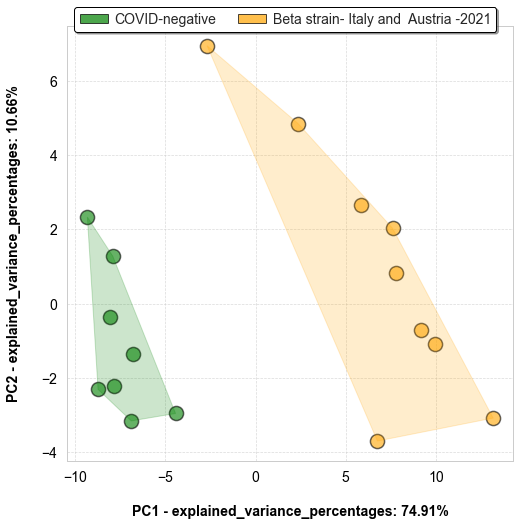

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data=pd.concat([Healthy,SARS_CoV_2],axis=1)

color_map = {
    'COVID-negative': 'green',     
    'Beta strain- Italy and  Austria -2021': 'orange',        

}
data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0, 1.06), ncol=5, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


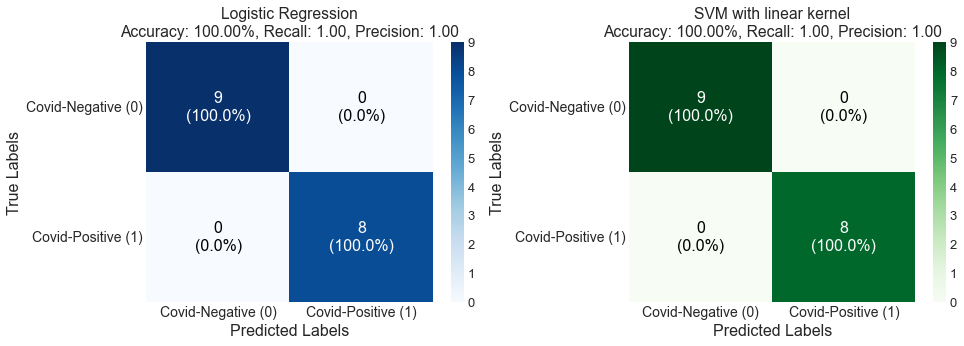

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

conf_matrix_log_GSE189039 =conf_matrix_log
accuracy_log_GSE189039 = accuracy_log
recall_log_GSE189039 = recall_log
precision_log_GSE189039 = precision_log
conf_matrix_svm_GSE189039 =conf_matrix_svm
accuracy_svm_GSE189039 = accuracy_svm
recall_svm_GSE189039 = recall_svm
precision_svm_GSE189039 = precision_svm


# GSE201530

In [45]:

ALL = pd.read_csv('GSE201530-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('Omicron strain- Austria -2021 and 2022')]]



In [46]:
Healthy

,COVID-negative (1),COVID-negative (2),COVID-negative (3),COVID-negative (4),COVID-negative (5),COVID-negative (6),COVID-negative (7),COVID-negative (8)
Gene Symbol,,,,,,,,
A1BG,35,24,24,17,2,16,5,24
A1CF,7,11,4,5,13,0,7,4
A2M,423,321,341,530,570,172,572,757
A2ML1,25,11,31,24,10,14,12,19
A3GALT2,94,54,55,95,61,48,90,135
...,...,...,...,...,...,...,...,...
ZYG11A,15,9,7,7,3,1,10,13
ZYG11B,3393,2992,3344,2925,2892,1605,3538,2989
ZYX,15498,14699,13105,11358,6286,16681,11960,14935


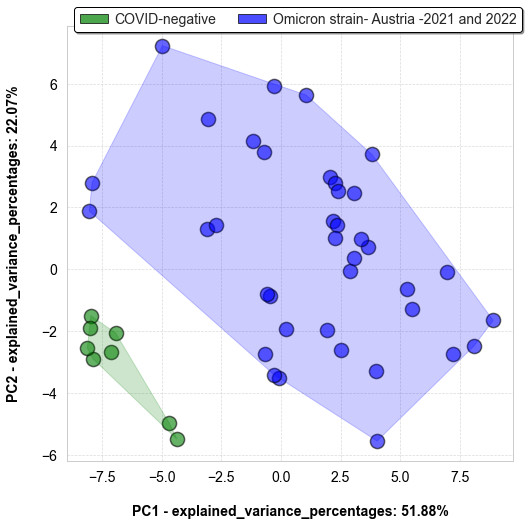

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
color_map = {
    'COVID-negative': 'green',     
    'Omicron strain- Austria -2021 and 2022': 'blue',        

}


data=pd.concat([Healthy,SARS_CoV_2],axis=1)

data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()


plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0, 1.06), ncol=5, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


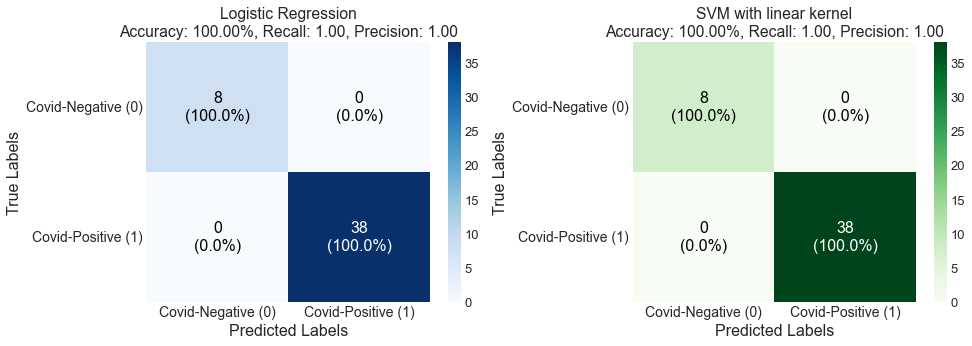

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

conf_matrix_log_GSE201530 =conf_matrix_log
accuracy_log_GSE201530 = accuracy_log
recall_log_GSE201530 = recall_log
precision_log_GSE201530 = precision_log
conf_matrix_svm_GSE201530 =conf_matrix_svm
accuracy_svm_GSE201530 = accuracy_svm
recall_svm_GSE201530 = recall_svm
precision_svm_GSE201530 = precision_svm


In [49]:
cumulative_conf_matrix_log = (conf_matrix_log_GSE157103 + conf_matrix_log_GSE171110 +
                              conf_matrix_log_GSE189039 + conf_matrix_log_GSE201530)

cumulative_conf_matrix_svm = (conf_matrix_svm_GSE157103 + conf_matrix_svm_GSE171110 +
                              conf_matrix_svm_GSE189039 + conf_matrix_svm_GSE201530)

print("Cumulative Confusion Matrix for Logistic Regression:")
print(cumulative_conf_matrix_log)
print("Cumulative Confusion Matrix for SVM:")
print(cumulative_conf_matrix_svm)

Cumulative Confusion Matrix for Logistic Regression:
[[ 31   6]
 [  4 184]]
Cumulative Confusion Matrix for SVM:
[[ 34   3]
 [  5 183]]


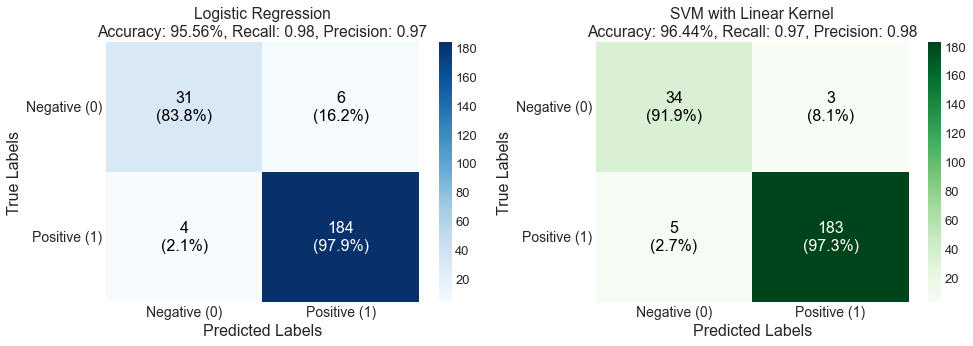

In [50]:



cumulative_conf_matrix_log = (conf_matrix_log_GSE157103 + conf_matrix_log_GSE171110 +
                              conf_matrix_log_GSE189039 + conf_matrix_log_GSE201530)

cumulative_conf_matrix_svm = (conf_matrix_svm_GSE157103 + conf_matrix_svm_GSE171110 +
                              conf_matrix_svm_GSE189039 + conf_matrix_svm_GSE201530)

accuracy_log = np.trace(cumulative_conf_matrix_log) / np.sum(cumulative_conf_matrix_log)
recall_log = cumulative_conf_matrix_log[1, 1] / (cumulative_conf_matrix_log[1, 1] + cumulative_conf_matrix_log[1, 0])
precision_log = cumulative_conf_matrix_log[1, 1] / (cumulative_conf_matrix_log[1, 1] + cumulative_conf_matrix_log[0, 1])

accuracy_svm = np.trace(cumulative_conf_matrix_svm) / np.sum(cumulative_conf_matrix_svm)
recall_svm = cumulative_conf_matrix_svm[1, 1] / (cumulative_conf_matrix_svm[1, 1] + cumulative_conf_matrix_svm[1, 0])
precision_svm = cumulative_conf_matrix_svm[1, 1] / (cumulative_conf_matrix_svm[1, 1] + cumulative_conf_matrix_svm[0, 1])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cumulative_conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(cumulative_conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Negative (0)', 'Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Negative (0)', 'Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(cumulative_conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(cumulative_conf_matrix_svm, ax[1])
title_svm = f'SVM with Linear Kernel\nAccuracy: {accuracy_svm*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Negative (0)', 'Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Negative (0)', 'Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()


# Test 

# GSE152418

In [172]:

ALL = pd.read_csv('GSE152418-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
COVID_19_Moderate = dddata[[col for col in dddata.columns if col.startswith('COVID-19_Moderate')]]
COVID_19_Severe= dddata[[col for col in dddata.columns if col.startswith('COVID-19_Severe')]]
COVID_19_ICU= dddata[[col for col in dddata.columns if col.startswith('COVID-19_ICU')]]

In [173]:
ALL

,Gene Symbol,COVID-19_Moderate (1),COVID-19_Severe (1),COVID-19_Severe (2),COVID-19_ICU (1),COVID-19_Severe (3),COVID-19_Moderate (2),COVID-19_Severe (4),COVID-19_ICU (2),COVID-19_Severe (5),COVID-19_Moderate (3),COVID-19_ICU (3),COVID-19_Severe (6),COVID-19_ICU (4),COVID-19_Severe (7),COVID-19_Severe (8),COVID-19_Moderate (4),COVID-negative (1),COVID-negative (2),COVID-negative (3),COVID-negative (4),COVID-negative (5),COVID-negative (6),COVID-negative (7),COVID-negative (8),COVID-negative (9),COVID-negative (10),COVID-negative (11),COVID-negative (12),COVID-negative (13),COVID-negative (14),COVID-negative (15),COVID-negative (16),COVID-negative (17)
0,OR4F5,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0
1,OR4F29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,OR4F16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SAMD11,1,1,0,2,0,0,0,9,0,7,3,0,0,2,0,2,1,2,0,1,1,0,1,4,1,0,0,2,1,1,1,0,0
4,NOC2L,1198,1491,2139,1841,1623,1298,1379,1596,1266,2004,1017,1345,1750,1724,1530,1485,2381,1964,1669,1883,1940,2027,2054,1892,1897,2229,1862,1596,1706,2162,1801,1587,1592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19439,LOC102723407,151,1313,5028,2240,5159,2878,107,1685,1950,8633,2713,1495,2099,1063,1731,5696,25,20,43,108,286,69,787,37,58,90,45,369,895,180,141,138,927
19440,LOC124905564,31,56,42,42,66,40,24,32,49,44,48,22,44,113,120,40,69,96,88,57,53,52,76,62,48,88,38,63,62,83,30,60,77
19441,LOC124905693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19442,LOC124903857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


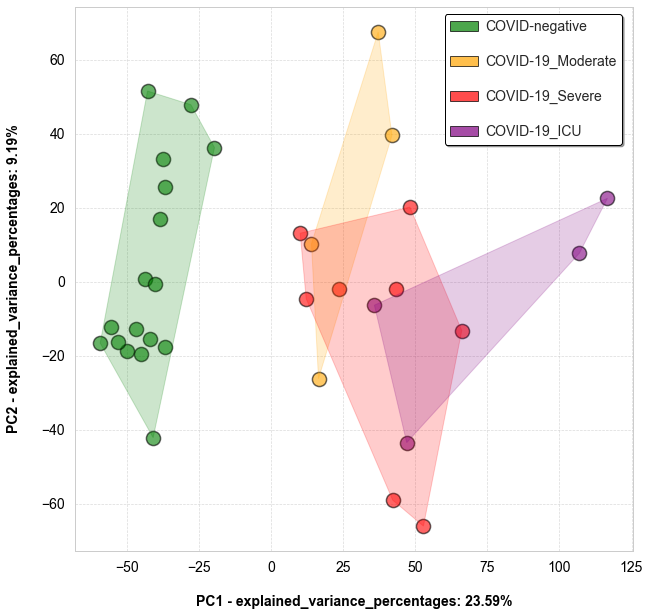

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data=pd.concat([Healthy,COVID_19_Moderate,COVID_19_Severe,COVID_19_ICU],axis=1)
data_transposed = data.transpose()
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()

color_map = {
    'COVID-negative': 'green',     
    'COVID-19_Moderate': 'orange',    
    'COVID-19_Severe': 'red', 
    'COVID-19_ICU':'purple'

}

plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(10, 10))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)



legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(.65, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


             COVID-negative (1)  COVID-negative (2)  COVID-negative (3)  \
Gene Symbol                                                               
OR4F5                         0                   0                   0   
OR4F29                        0                   0                   0   
OR4F16                        0                   0                   0   
SAMD11                        1                   2                   0   
NOC2L                      2381                1964                1669   

             COVID-negative (4)  COVID-negative (5)  COVID-negative (6)  \
Gene Symbol                                                               
OR4F5                         0                   0                   0   
OR4F29                        0                   0                   0   
OR4F16                        0                   0                   0   
SAMD11                        1                   1                   0   
NOC2L                   

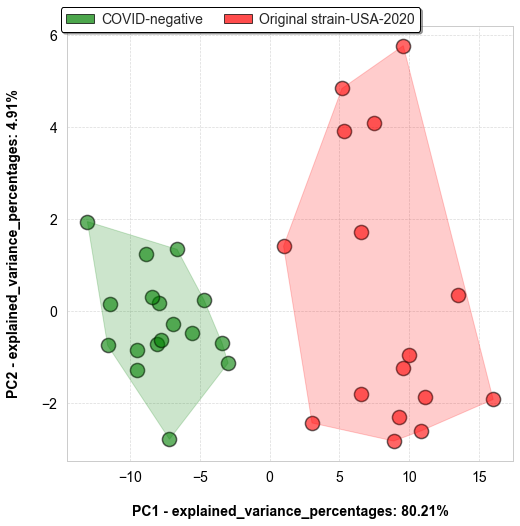

In [175]:
dff=data_transposed.T
dff.columns

import pandas as pd

healthy_count = 0
covid_count = 0

new_columns = []
for col in dff.columns:
    if "COVID-negative" in col:
        healthy_count += 1
        new_columns.append(f"COVID-negative ({healthy_count})")
    else:
        covid_count += 1
        new_columns.append(f"Original strain-USA-2020 ({covid_count})")

dff.columns = new_columns

print(dff.head())

dddata = dff.copy()


Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]

SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('Original strain-USA-2020')]]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

color_map = {
    'COVID-negative': 'green',     
    'Original strain-USA-2020': 'red',       

}

data=pd.concat([Healthy,SARS_CoV_2],axis=1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(-0.03, 1.06), ncol=5, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


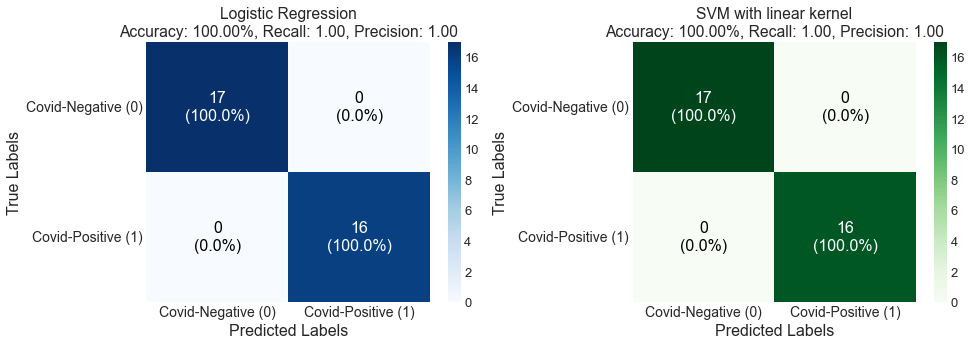

In [176]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

conf_matrix_log_GSE152418 =conf_matrix_log
accuracy_log_GSE152418 = accuracy_log
recall_log_GSE152418 = recall_log
precision_log_GSE152418 = precision_log
conf_matrix_svm_GSE152418 =conf_matrix_svm
accuracy_svm_GSE152418 = accuracy_svm
recall_svm_GSE152418 = recall_svm
precision_svm_GSE152418 = precision_svm


# PMC8202013

In [177]:

ALL = pd.read_csv('PMC8202013-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]
INFL = dddata[[col for col in dddata.columns if col.startswith('INFL')]]
SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('Original strain-Switzerland-2020')]]



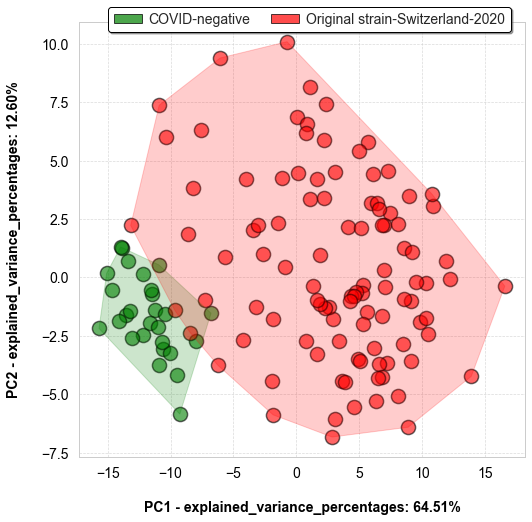

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

color_map = {
    'COVID-negative': 'green',     
    'Original strain-Switzerland-2020': 'red',        

}

data=pd.concat([Healthy,SARS_CoV_2],axis=1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch



data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()



plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(8, 8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=200, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=1.5)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - explained_variance_percentages: {explained_variance_percentages[0]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - explained_variance_percentages: {explained_variance_percentages[1]}', fontsize=14, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=14, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=14, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.05, 1.051), ncol=2, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


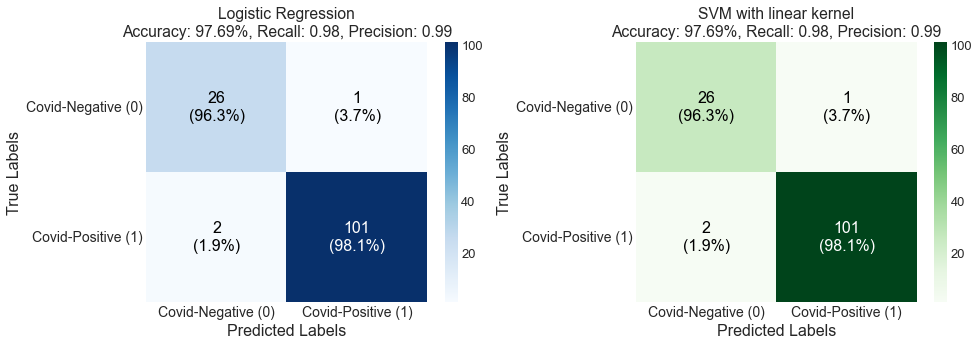

In [179]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()
conf_matrix_log_PMC8202013 =conf_matrix_log
accuracy_log_PMC8202013 = accuracy_log
recall_log_PMC8202013 = recall_log
precision_log_PMC8202013 = precision_log
conf_matrix_svm_PMC8202013 =conf_matrix_svm
accuracy_svm_PMC8202013 = accuracy_svm
recall_svm_PMC8202013 = recall_svm
precision_svm_PMC8202013 = precision_svm

# GSE161731

In [180]:

ALL = pd.read_csv('GSE161731-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

Healthy = dddata[[col for col in dddata.columns if col.startswith('COVID-negative')]]

SARS_CoV_2 = dddata[[col for col in dddata.columns if col.startswith('SARS_CoV_2_Yes')]]

SARS_CoV_2.columns = SARS_CoV_2.columns.str.replace('SARS_CoV_2_Yes', 'Original strain-USA -2020')

data=pd.concat([Healthy,SARS_CoV_2],axis=1)

color_map = {
    'COVID-negative': 'green',     
    'Original strain-USA -2020': 'red',         

}




data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()







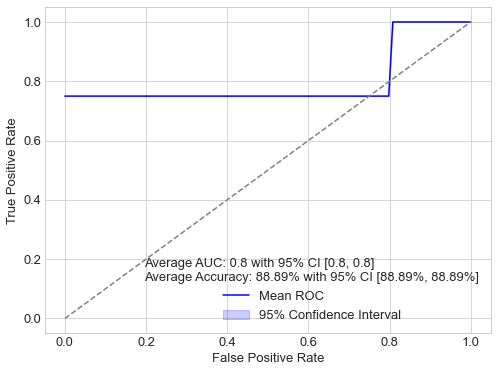

Accuracy: 0.8889 with 95% CI [0.8889, 0.8889]
AUC: 0.8000 with 95% CI [0.8000, 0.8000]


In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import resample

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(5)], index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes  

X = principal_df.drop(columns=['Group'])
y = labels

n_iterations = 1
auc_scores = []
accuracy_scores = []
all_fprs = np.linspace(0, 1, 100)
all_tprs = []

for _ in range(n_iterations):
    X_resampled, y_resampled = resample(X, y, replace=True, stratify=y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_prob))
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(all_fprs, fpr, tpr)
    all_tprs.append(tpr_interp)

mean_accuracy = np.mean(accuracy_scores)
ci_accuracy_lower = mean_accuracy - 1.96 * np.std(accuracy_scores) / np.sqrt(n_iterations)
ci_accuracy_upper = mean_accuracy + 1.96 * np.std(accuracy_scores) / np.sqrt(n_iterations)
mean_auc = np.mean(auc_scores)
ci_auc_lower = mean_auc - 1.96 * np.std(auc_scores) / np.sqrt(n_iterations)
ci_auc_upper = mean_auc + 1.96 * np.std(auc_scores) / np.sqrt(n_iterations)

mean_tpr = np.mean(all_tprs, axis=0)
std_tpr = np.std(all_tprs, axis=0)
upper_tpr = np.minimum(mean_tpr + 1.96 * std_tpr, 1)  
lower_tpr = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

plt.figure(figsize=(8, 6))
plt.plot(all_fprs, mean_tpr, color='blue', label=f'Mean ROC')
plt.fill_between(all_fprs, lower_tpr, upper_tpr, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title=f'Average AUC: {mean_auc:.4} with 95% CI [{ci_auc_lower:.4}, {ci_auc_upper:.4}]\nAverage Accuracy: {mean_accuracy:.2%} with 95% CI [{ci_accuracy_lower:.2%}, {ci_accuracy_upper:.2%}]')
plt.grid(True)
plt.show()

print(f'Accuracy: {mean_accuracy:.4f} with 95% CI [{ci_accuracy_lower:.4f}, {ci_accuracy_upper:.4f}]')
print(f'AUC: {mean_auc:.4f} with 95% CI [{ci_auc_lower:.4f}, {ci_auc_upper:.4f}]')

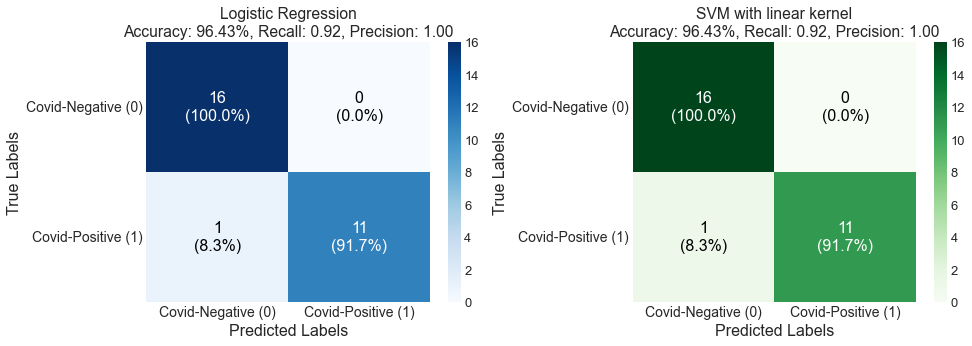

In [182]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()


conf_matrix_log_GSE161731 =conf_matrix_log
accuracy_log_GSE161731 = accuracy_log
recall_log_GSE161731 = recall_log
precision_log_GSE161731 = precision_log
conf_matrix_svm_GSE161731 =conf_matrix_svm
accuracy_svm_GSE161731 = accuracy_svm
recall_svm_GSE161731 = recall_svm
precision_svm_GSE161731 = precision_svm

In [183]:

ALL = pd.read_csv('GSE166190_adults-Ready.csv')



dddata = ALL.set_index('Gene Symbol')

dddata

,Adult_Positive_Interval1 (1),Adult_Positive_Interval3 (1),Adult_Positive_Interval4 (1),Adult_Positive_Interval5 (1),Adult_Positive_Interval2 (1),Adult_Positive_Interval3 (2),Adult_Positive_Interval5 (2),Adult_Positive_Interval1 (2),Adult_Positive_Interval2 (2),Adult_Positive_Interval3 (3),Adult_Positive_Interval4 (2),Adult_Positive_Interval5 (3),Adult_Positive_Interval1 (3),Adult_Positive_Interval2 (3),Adult_Positive_Interval3 (4),Adult_Positive_Interval4 (3),Adult_Positive_Interval1 (4),Adult_Positive_Interval2 (4),Adult_Positive_Interval4 (4),Adult_Positive_Interval5 (4),Adult_Negative (1),Adult_Negative (2),Adult_Negative (3),Adult_Negative (4),Adult_Positive_Interval1 (5),Adult_Positive_Interval2 (5),Adult_Positive_Interval3 (5),Adult_Positive_Interval1 (6),Adult_Positive_Interval2 (6),Adult_Positive_Interval3 (6),Adult_Positive_Interval4 (5),Adult_Positive_Interval5 (5),Adult_Positive_Interval1 (7),Adult_Positive_Interval2 (7),Adult_Positive_Interval3 (7),Adult_Positive_Interval4 (6),Adult_Positive_Interval5 (6),Adult_Negative (5),Adult_Negative (6),Adult_Negative (7),Adult_Negative (8),Adult_Positive_Interval1 (8),Adult_Positive_Interval2 (8),Adult_Positive_Interval3 (8),Adult_Positive_Interval4 (7),Adult_Positive_Interval5 (7),Adult_Negative (12),Adult_Negative (13),Adult_Negative (14),Adult_Positive_Interval2 (9),Adult_Positive_Interval3 (9),Adult_Positive_Interval5 (8),Adult_Positive_Interval1 (9),Adult_Positive_Interval2 (10),Adult_Positive_Interval3 (10),Adult_Positive_Interval4 (8),Adult_Positive_Interval5 (9),Adult_Positive_Interval1 (10),Adult_Positive_Interval2 (11),Adult_Positive_Interval3 (11),Adult_Positive_Interval4 (9),Adult_Positive_Interval5 (10)
Gene Symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,0,0,4,3,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0
LOC112268260,22,22,23,19,34,24,25,12,14,16,16,10,17,21,23,22,14,11,16,15,35,30,19,22,20,18,23,11,10,12,15,13,15,15,7,12,11,30,50,22,38,19,16,24,18,15,21,25,28,13,14,16,7,15,20,20,19,8,11,14,9,32
OR4F29,1,1,1,0,1,1,1,1,1,1,0,3,3,4,4,5,1,2,0,1,1,1,1,1,2,1,0,0,0,0,0,0,1,1,1,0,0,2,1,0,1,1,1,1,0,1,2,2,1,1,1,1,0,2,1,1,2,2,2,1,1,1
LOC105378947,1,1,2,0,4,3,4,1,2,1,4,1,2,3,1,2,1,2,3,1,6,2,3,3,2,2,3,1,1,1,0,0,1,2,1,2,1,1,1,1,4,2,1,4,2,5,4,5,2,1,2,2,1,1,3,2,1,0,3,2,3,5
OR4F16,12,18,23,17,7,13,13,8,13,14,11,8,29,31,23,29,5,9,11,12,14,11,9,11,10,15,15,3,4,4,7,4,11,8,6,5,6,16,24,20,21,12,10,12,14,14,19,21,20,13,15,12,7,13,19,14,11,9,15,8,5,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND4L,1120,1407,1379,1105,608,1422,1752,921,1797,1537,1026,1057,1194,1048,690,1723,506,1433,1843,1292,420,1079,1022,938,1697,1435,1406,600,828,978,1127,909,352,317,333,308,525,425,311,345,619,326,352,426,493,117,97,1321,434,509,861,449,752,782,949,1400,975,707,886,901,464,1729
ND4,6339,8849,8264,6885,3324,8682,13880,4762,10269,8575,6325,6151,6969,6186,4799,13112,3101,8066,14287,9613,4588,9477,9367,7498,10635,10358,10483,5519,6402,9392,12210,8228,2876,2130,2716,3248,3618,3802,2647,4046,5716,2847,3153,3203,4348,1092,1027,11436,3492,3319,7042,4455,5820,5629,6913,12500,7731,5655,7519,7617,3886,14690
ND5,3071,3914,3575,2870,1350,3610,6691,2427,4636,3921,2700,2865,3036,2455,1800,6614,1416,3600,6024,4075,1561,4096,3797,3376,4641,4460,4674,2636,3000,4739,5395,3502,1508,991,1237,1379,1862,1745,1005,1888,2518,1502,1440,1297,2018,495,439,4938,1433,2427,5296,2728,2465,2394,2841,5291,3492,2875,3304,3215,1417,6081


In [184]:
HLTY = dddata[[col for col in dddata.columns if col.startswith('Adult_Negative')]]
Interval1 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval1')]]
Interval2 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval2')]]
Interval3 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval3')]]
Interval4 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval4')]]
Interval5 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval5')]]



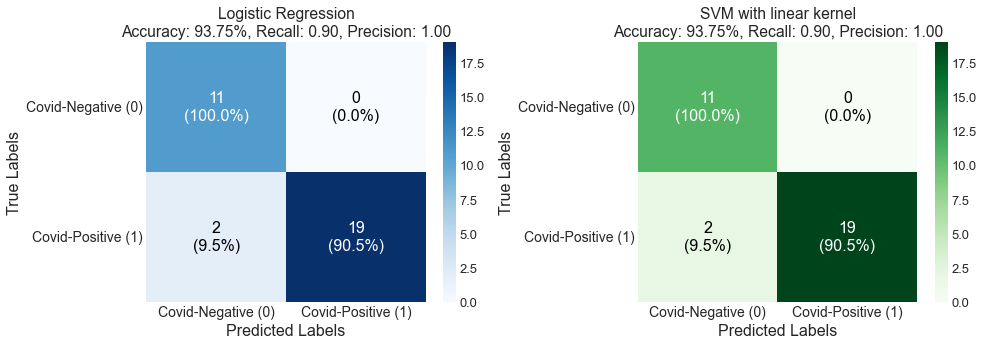

In [185]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

HLTY = dddata[[col for col in dddata.columns if col.startswith('Adult_Negative')]]
Interval1 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval1')]]
Interval2 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval2')]]
Interval3 = dddata[[col for col in dddata.columns if col.startswith('Adult_Positive_Interval3')]]

data = pd.concat([HLTY, Interval1, Interval2], axis=1)

data_transposed = data.transpose()[concatenated_list]

# Scale and log-transform the data
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

def assign_label(name):
    if 'Adult_Negative' in name:
        return 'Negative'
    elif any(interval in name for interval in ['Interval1', 'Interval2']):
        return 'Positive'
    else:
        return 'Unknown'  

principal_df['Group'] = principal_df.index.to_series().apply(assign_label)

labels = principal_df['Group'].astype('category').cat.codes

X = principal_df.drop(columns=['Group'])
y = labels

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)


svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)


def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_svm*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()


conf_matrix_log_GSE166190 = conf_matrix_log
accuracy_log_GSE166190 = accuracy_log
recall_log_GSE166190 = recall_log
precision_log_GSE166190 = precision_log
conf_matrix_svm_GSE166190 = conf_matrix_svm
accuracy_svm_GSE166190 = accuracy_svm
recall_svm_GSE166190 = recall_svm
precision_svm_GSE166190 = precision_svm


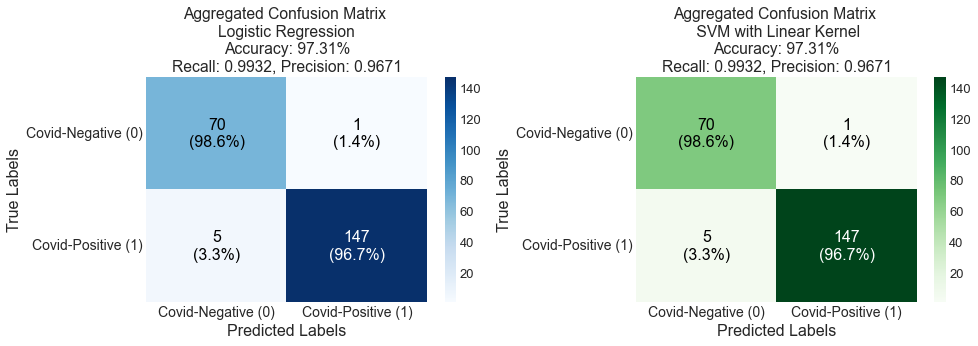

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

datasets = ['GSE152418', 'PMC8202013', 'GSE161731', 'GSE166190']

total_conf_matrix_log = np.zeros((2, 2))
total_conf_matrix_svm = np.zeros((2, 2))

for dataset in datasets:
    total_conf_matrix_log += eval(f'conf_matrix_log_{dataset}')
    total_conf_matrix_svm += eval(f'conf_matrix_svm_{dataset}')

def calculate_metrics(cm):
    tn = cm[0, 0]
    fn = cm[0, 1]
    fp = cm[1, 0]
    tp = cm[1, 1]

    accuracy = (tp + tn) / np.sum(cm)
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    return accuracy, recall, precision

accuracy_log, recall_log, precision_log = calculate_metrics(total_conf_matrix_log)
accuracy_svm, recall_svm, precision_svm = calculate_metrics(total_conf_matrix_svm)

def add_percentage(cm, ax):
    """Utility function to add percentage and count annotations on the confusion matrix."""
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{int(cm[i, j])}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(total_conf_matrix_log, annot=False, ax=ax[0], cmap="Blues")
add_percentage(total_conf_matrix_log, ax[0])
ax[0].set_title(f'Aggregated Confusion Matrix \nLogistic Regression\nAccuracy: {accuracy_log*100:.2f}%\nRecall: {recall_log:.4f}, Precision: {precision_log:.4f}')
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

sns.heatmap(total_conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens")
add_percentage(total_conf_matrix_svm, ax[1])
ax[1].set_title(f'Aggregated Confusion Matrix \n SVM with Linear Kernel\nAccuracy: {accuracy_svm*100:.2f}%\nRecall: {recall_svm:.4f}, Precision: {precision_svm:.4f}')
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

plt.tight_layout()
plt.show()


In [97]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# data=pd.concat([HLTY,Interval1],axis=1)

# data_transposed = data.transpose()[concatenated_list]
# scaler = StandardScaler()
# data_scaled = np.log2(data_transposed + 1)

# pca = PCA(n_components=5)
# principal_components = pca.fit_transform(data_scaled)
# principal_df = pd.DataFrame(data=principal_components, 
#                             columns=[f'PC{i+1}' for i in range(5)], 
#                             index=data_transposed.index)

# principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
# labels = principal_df['Group'].astype('category').cat.codes

# X = principal_df.drop(columns=['Group'])
# y = labels

# log_reg = LogisticRegression()
# log_reg.fit(X, y)
# y_pred_log = log_reg.predict(X)
# conf_matrix_log = confusion_matrix(y, y_pred_log)
# accuracy_log = accuracy_score(y, y_pred_log)
# recall_log = recall_score(y, y_pred_log)
# precision_log = precision_score(y, y_pred_log)

# svm = SVC(kernel='linear', probability=True)
# svm.fit(X, y)
# y_pred_svm = svm.predict(X)
# conf_matrix_svm = confusion_matrix(y, y_pred_svm)
# accuracy_svm = accuracy_score(y, y_pred_svm)
# recall_svm = recall_score(y, y_pred_svm)
# precision_svm = precision_score(y, y_pred_svm)

# def add_percentage(cm, ax):
#     for i in range(cm.shape[0]):
#         row_sum = cm[i, :].sum()
#         for j in range(cm.shape[1]):
#             percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
#             text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
#             ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

# fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
# add_percentage(conf_matrix_log, ax[0])
# title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
# ax[0].set_title(title_log)
# ax[0].set_xlabel('Predicted Labels', fontsize=16)
# ax[0].set_ylabel('True Labels', fontsize=16)
# ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
# add_percentage(conf_matrix_svm, ax[1])
# title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
# ax[1].set_title(title_svm)
# ax[1].set_xlabel('Predicted Labels', fontsize=16)
# ax[1].set_ylabel('True Labels', fontsize=16)
# ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# plt.tight_layout()
# plt.show()
# conf_matrix_log_GSE166190 =conf_matrix_log
# accuracy_log_GSE166190 = accuracy_log
# recall_log_GSE166190 = recall_log
# precision_log_GSE166190 = precision_log
# conf_matrix_svm_GSE166190 =conf_matrix_svm
# accuracy_svm_GSE166190 = accuracy_svm
# recall_svm_GSE166190 = recall_svm
# precision_svm_GSE166190 = precision_svm

In [98]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# data=pd.concat([HLTY,Interval2],axis=1)

# data_transposed = data.transpose()[concatenated_list]
# scaler = StandardScaler()
# data_scaled = np.log2(data_transposed + 1)

# pca = PCA(n_components=5)
# principal_components = pca.fit_transform(data_scaled)
# principal_df = pd.DataFrame(data=principal_components, 
#                             columns=[f'PC{i+1}' for i in range(5)], 
#                             index=data_transposed.index)

# principal_df['Group'] = principal_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
# labels = principal_df['Group'].astype('category').cat.codes

# X = principal_df.drop(columns=['Group'])
# y = labels

# log_reg = LogisticRegression()
# log_reg.fit(X, y)
# y_pred_log = log_reg.predict(X)
# conf_matrix_log = confusion_matrix(y, y_pred_log)
# accuracy_log = accuracy_score(y, y_pred_log)
# recall_log = recall_score(y, y_pred_log)
# precision_log = precision_score(y, y_pred_log)

# svm = SVC(kernel='linear', probability=True)
# svm.fit(X, y)
# y_pred_svm = svm.predict(X)
# conf_matrix_svm = confusion_matrix(y, y_pred_svm)
# accuracy_svm = accuracy_score(y, y_pred_svm)
# recall_svm = recall_score(y, y_pred_svm)
# precision_svm = precision_score(y, y_pred_svm)

# def add_percentage(cm, ax):
#     for i in range(cm.shape[0]):
#         row_sum = cm[i, :].sum()
#         for j in range(cm.shape[1]):
#             percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
#             text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
#             ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

# fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
# add_percentage(conf_matrix_log, ax[0])
# title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
# ax[0].set_title(title_log)
# ax[0].set_xlabel('Predicted Labels', fontsize=16)
# ax[0].set_ylabel('True Labels', fontsize=16)
# ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
# add_percentage(conf_matrix_svm, ax[1])
# title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
# ax[1].set_title(title_svm)
# ax[1].set_xlabel('Predicted Labels', fontsize=16)
# ax[1].set_ylabel('True Labels', fontsize=16)
# ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# plt.tight_layout()
# plt.show()
# conf_matrix_log_GSE166190_2 =conf_matrix_log
# accuracy_log_GSE166190_2 = accuracy_log
# recall_log_GSE166190_2 = recall_log
# precision_log_GSE166190_2 = precision_log
# conf_matrix_svm_GSE166190_2 =conf_matrix_svm
# accuracy_svm_GSE166190_2 = accuracy_svm
# recall_svm_GSE166190_2 = recall_svm
# precision_svm_GSE166190_2 = precision_svm

In [100]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# datasets = ['GSE152418', 'PMC8202013', 'GSE161731', 'GSE166190']

# total_conf_matrix_log = np.zeros((2, 2))
# total_conf_matrix_svm = np.zeros((2, 2))

# for dataset in datasets:
#     total_conf_matrix_log += eval(f'conf_matrix_log_{dataset}')
#     total_conf_matrix_svm += eval(f'conf_matrix_svm_{dataset}')

# def calculate_metrics(cm):
#     tn = cm[0, 0]
#     fn = cm[0, 1]
#     fp = cm[1, 0]
#     tp = cm[1, 1]

#     accuracy = (tp + tn) / np.sum(cm)
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     return accuracy, recall, precision

# accuracy_log, recall_log, precision_log = calculate_metrics(total_conf_matrix_log)
# accuracy_svm, recall_svm, precision_svm = calculate_metrics(total_conf_matrix_svm)

# def add_percentage(cm, ax):
#     """Utility function to add percentage and count annotations on the confusion matrix."""
#     for i in range(cm.shape[0]):
#         row_sum = cm[i, :].sum()
#         for j in range(cm.shape[1]):
#             percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
#             text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
#             ax.text(j+.5, i+.5, f'{int(cm[i, j])}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

# fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# sns.heatmap(total_conf_matrix_log, annot=False, ax=ax[0], cmap="Blues")
# add_percentage(total_conf_matrix_log, ax[0])
# ax[0].set_title(f'Aggregated Confusion Matrix \nLogistic Regression\nAccuracy: {accuracy_log*100:.2f}%\nRecall: {recall_log:.4f}, Precision: {precision_log:.4f}')
# ax[0].set_xlabel('Predicted Labels', fontsize=16)
# ax[0].set_ylabel('True Labels', fontsize=16)
# ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# sns.heatmap(total_conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens")
# add_percentage(total_conf_matrix_svm, ax[1])
# ax[1].set_title(f'Aggregated Confusion Matrix \n SVM with Linear Kernel\nAccuracy: {accuracy_svm*100:.2f}%\nRecall: {recall_svm:.4f}, Precision: {precision_svm:.4f}')
# ax[1].set_xlabel('Predicted Labels', fontsize=16)
# ax[1].set_ylabel('True Labels', fontsize=16)
# ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# plt.tight_layout()
# plt.show()


In [154]:
import pandas as pd

def tpm_normalize(df):
    return df.div(df.sum(axis=0), axis=1) * 1e6

def relabel_columns(df, label):
    df.columns = [f"{label} ({i+1})" for i in range(df.shape[1])]
    return df

def dedup(df):
    return df.loc[~df.index.duplicated(keep="first")]


# GSE152418
df1 = pd.read_csv("GSE152418-Ready.csv").set_index("Gene Symbol")
df1 = dedup(df1)
Healthy1 = relabel_columns(df1[[col for col in df1.columns if col.startswith("COVID-negative")]], "covid-negative")
Positive1 = relabel_columns(pd.concat([
    df1[[col for col in df1.columns if col.startswith("COVID-19_Moderate")]],
    df1[[col for col in df1.columns if col.startswith("COVID-19_Severe")]],
    df1[[col for col in df1.columns if col.startswith("COVID-19_ICU")]]
], axis=1), "covid-positive")

# PMC8202013
df2 = pd.read_csv("PMC8202013-Ready.csv").set_index("Gene Symbol")
df2 = dedup(df2)
Healthy2 = relabel_columns(df2[[col for col in df2.columns if col.startswith("COVID-negative")]], "covid-negative")
Positive2 = relabel_columns(df2[[col for col in df2.columns if col.startswith("Original strain-Switzerland-2020")]], "covid-positive")

# GSE161731
df3 = pd.read_csv("GSE161731-Ready.csv").set_index("Gene Symbol")
df3 = dedup(df3)
Healthy3 = relabel_columns(df3[[col for col in df3.columns if col.startswith("COVID-negative")]], "covid-negative")
Positive3 = relabel_columns(df3[[col for col in df3.columns if col.startswith("SARS_CoV_2_Yes")]], "covid-positive")

# GSE166190_adults
df4 = pd.read_csv("GSE166190_adults-Ready.csv").set_index("Gene Symbol")
df4 = dedup(df4)
Healthy4 = relabel_columns(df4[[col for col in df4.columns if col.startswith("Adult_Negative")]], "covid-negative")
Positive4 = relabel_columns(pd.concat([
    df4[[col for col in df4.columns if col.startswith(f"Adult_Positive_Interval{i}")]]
    for i in range(1, 3)  # changed from range(1, 6) to range(1, 4)
], axis=1), "covid-positive")


# --- Find common genes ---
datasets = [Healthy1, Positive1, Healthy2, Positive2, Healthy3, Positive3, Healthy4, Positive4]
common_genes = set(datasets[0].index)
for df in datasets[1:]:
    df = dedup(df)
    common_genes &= set(df.index)
common_genes = sorted(list(common_genes))

# --- TPM normalize safely with aligned index ---
def safe_tpm(df):
    df = dedup(df)
    df = df.loc[common_genes]  # aligned ordering
    return tpm_normalize(df)

Healthy_all = [safe_tpm(df) for df in [Healthy1, Healthy2, Healthy3, Healthy4]]
Positive_all = [safe_tpm(df) for df in [Positive1, Positive2, Positive3, Positive4]]

# --- Combine and save ---
final_df = pd.concat(Healthy_all + Positive_all, axis=1)
final_df.to_csv("Combined_TPM_Normalized_Dataset.csv")


In [155]:
print("GSE152418:", Positive1.shape[1])
print("PMC8202013:", Positive2.shape[1])
print("GSE161731:", Positive3.shape[1])
print("GSE166190:", Positive4.shape[1])

print("After TPM and alignment:")
print([df.shape[1] for df in Positive_all])


GSE152418: 16
PMC8202013: 103
GSE161731: 12
GSE166190: 21
After TPM and alignment:
[16, 103, 12, 21]


In [156]:
print("Total columns in final_df:", final_df.shape[1])
print("Total covid-positive samples:", sum("covid-positive" in col for col in final_df.columns))
print("Total covid-negative samples:", sum("covid-negative" in col for col in final_df.columns))


Total columns in final_df: 223
Total covid-positive samples: 152
Total covid-negative samples: 71


In [157]:
# Sanity check
print("In-memory final_df shape:", final_df.shape)

# Reload from disk
check = pd.read_csv("Combined_TPM_Normalized_Dataset.csv", index_col=0)
print("Saved file shape:", check.shape)
print("COVID-positive in file:", sum("covid-positive" in col for col in check.columns))
print("COVID-negative in file:", sum("covid-negative" in col for col in check.columns))


In-memory final_df shape: (12997, 223)
Saved file shape: (12997, 223)
COVID-positive in file: 152
COVID-negative in file: 71


In [158]:
labels = pd.Series(["covid-negative" if "covid-negative" in col else "covid-positive"
                    for col in final_df.columns], index=final_df.columns, name="label")
labels.value_counts()


covid-positive    152
covid-negative     71
Name: label, dtype: int64

In [159]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Combined_TPM_Normalized_Dataset.csv", index_col=0)

# Separate column groups
neg_cols = [col for col in df.columns if "covid-negative" in col]
pos_cols = [col for col in df.columns if "covid-positive" in col]

# Create new names
new_neg_cols = [f"covid-negative ({i+1})" for i in range(len(neg_cols))]
new_pos_cols = [f"covid-positive ({i+1})" for i in range(len(pos_cols))]

# Combine into a rename mapping
rename_map = dict(zip(neg_cols, new_neg_cols))
rename_map.update(zip(pos_cols, new_pos_cols))

# Rename columns
df.rename(columns=rename_map, inplace=True)

# Optional: save the cleaned version
df.to_csv("Combined_TPM_Normalized_Dataset_Renamed.csv")



In [160]:
df

,covid-negative (1),covid-negative (2),covid-negative (3),covid-negative (4),covid-negative (5),covid-negative (6),covid-negative (7),covid-negative (8),covid-negative (9),covid-negative (10),covid-negative (11),covid-negative (12),covid-negative (13),covid-negative (14),covid-negative (15),covid-negative (16),covid-negative (17),covid-negative (18),covid-negative (19),covid-negative (20),covid-negative (21),covid-negative (22),covid-negative (23),covid-negative (24),covid-negative (25),covid-negative (26),covid-negative (27),covid-negative (28),covid-negative (29),covid-negative (30),covid-negative (31),covid-negative (32),covid-negative (33),covid-negative (34),covid-negative (35),covid-negative (36),covid-negative (37),covid-negative (38),covid-negative (39),covid-negative (40),covid-negative (41),covid-negative (42),covid-negative (43),covid-negative (44),covid-negative (45),covid-negative (46),covid-negative (47),covid-negative (48),covid-negative (49),covid-negative (50),covid-negative (51),covid-negative (52),covid-negative (53),covid-negative (54),covid-negative (55),covid-negative (56),covid-negative (57),covid-negative (58),covid-negative (59),covid-negative (60),covid-negative (61),covid-negative (62),covid-negative (63),covid-negative (64),covid-negative (65),covid-negative (66),covid-negative (67),covid-negative (68),covid-negative (69),covid-negative (70),covid-negative (71),covid-positive (1),covid-positive (2),covid-positive (3),covid-positive (4),covid-positive (5),covid-positive (6),covid-positive (7),covid-positive (8),covid-positive (9),covid-positive (10),covid-positive (11),covid-positive (12),covid-positive (13),covid-positive (14),covid-positive (15),covid-positive (16),covid-positive (17),covid-positive (18),covid-positive (19),covid-positive (20),covid-positive (21),covid-positive (22),covid-positive (23),covid-positive (24),covid-positive (25),covid-positive (26),covid-positive (27),covid-positive (28),covid-positive (29),covid-positive (30),covid-positive (31),covid-positive (32),covid-positive (33),covid-positive (34),covid-positive (35),covid-positive (36),covid-positive (37),covid-positive (38),covid-positive (39),covid-positive (40),covid-positive (41),covid-positive (42),covid-positive (43),covid-positive (44),covid-positive (45),covid-positive (46),covid-positive (47),covid-positive (48),covid-positive (49),covid-positive (50),covid-positive (51),covid-positive (52),covid-positive (53),covid-positive (54),covid-positive (55),covid-positive (56),covid-positive (57),covid-positive (58),covid-positive (59),covid-positive (60),covid-positive (61),covid-positive (62),covid-positive (63),covid-positive (64),covid-positive (65),covid-positive (66),covid-positive (67),covid-positive (68),covid-positive (69),covid-positive (70),covid-positive (71),covid-positive (72),covid-positive (73),covid-positive (74),covid-positive (75),covid-positive (76),covid-positive (77),covid-positive (78),covid-positive (79),covid-positive (80),covid-positive (81),covid-positive (82),covid-positive (83),covid-positive (84),covid-positive (85),covid-positive (86),covid-positive (87),covid-positive (88),covid-positive (89),covid-positive (90),covid-positive (91),covid-positive (92),covid-positive (93),covid-positive (94),covid-positive (95),covid-positive (96),covid-positive (97),covid-positive (98),covid-positive (99),covid-positive (100),covid-positive (101),covid-positive (102),covid-positive (103),covid-positive (104),covid-positive (105),covid-positive (106),covid-positive (107),covid-positive (108),covid-positive (109),covid-positive (110),covid-positive (111),covid-positive (112),covid-positive (113),covid-positive (114),covid-positive (115),covid-positive (116),covid-positive (117),covid-positive (118),covid-positive (119),covid-positive (120),covid-positive (121),covid-positive (122),covid-positive (123),covid-positive (124),covid-positive (125),covid-positive (126),covid-positive (127),covid-positive (128),covid-po

In [2]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load TPM-normalized dataset
# df = pd.read_csv("Combined_TPM_Normalized_Dataset.csv", index_col=0)

# # Transpose so samples are rows
# data_transposed = df.T[concatenated_list]

# # Standardize + log2 transform
# data_scaled = StandardScaler().fit_transform(np.log2(data_transposed + 1))

# # PCA
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(data_scaled)

# principal_df = pd.DataFrame(principal_components, 
#                             columns=[f'PC{i+1}' for i in range(10)], 
#                             index=data_transposed.index)

# # Label assignment based on column names
# def assign_label(name):
#     if "covid-negative" in name:
#         return "Negative"
#     elif "covid-positive" in name:
#         return "Positive"
#     else:
#         return "Unknown"

# principal_df["Group"] = principal_df.index.to_series().apply(assign_label)
# labels = principal_df["Group"].astype("category").cat.codes  # 0 = Negative, 1 = Positive

# # Train/Test data
# X = principal_df.drop(columns=["Group"])
# y = labels

# # Logistic Regression
# log_reg = LogisticRegression()
# log_reg.fit(X, y)
# y_pred_log = log_reg.predict(X)
# conf_matrix_log = confusion_matrix(y, y_pred_log)
# accuracy_log = accuracy_score(y, y_pred_log)
# recall_log = recall_score(y, y_pred_log)
# precision_log = precision_score(y, y_pred_log)

# # SVM
# svm = SVC(kernel='linear', probability=True)
# svm.fit(X, y)
# y_pred_svm = svm.predict(X)
# conf_matrix_svm = confusion_matrix(y, y_pred_svm)
# accuracy_svm = accuracy_score(y, y_pred_svm)
# recall_svm = recall_score(y, y_pred_svm)
# precision_svm = precision_score(y, y_pred_svm)

# # Helper to add percentages to heatmap
# def add_percentage(cm, ax):
#     for i in range(cm.shape[0]):
#         row_sum = cm[i, :].sum()
#         for j in range(cm.shape[1]):
#             percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
#             text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
#             ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

# # Plot confusion matrices
# fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
# add_percentage(conf_matrix_log, ax[0])
# ax[0].set_title(f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}')
# ax[0].set_xlabel('Predicted Labels', fontsize=16)
# ax[0].set_ylabel('True Labels', fontsize=16)
# ax[0].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[0].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
# add_percentage(conf_matrix_svm, ax[1])
# ax[1].set_title(f'SVM with linear kernel\nAccuracy: {accuracy_svm*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}')
# ax[1].set_xlabel('Predicted Labels', fontsize=16)
# ax[1].set_ylabel('True Labels', fontsize=16)
# ax[1].set_xticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14)
# ax[1].set_yticklabels(['Covid-Negative (0)', 'Covid-Positive (1)'], fontsize=14, rotation=0)

# plt.tight_layout()
# plt.show()

# # Save metrics (optional)
# conf_matrix_log_GSE166190 = conf_matrix_log
# accuracy_log_GSE166190 = accuracy_log
# recall_log_GSE166190 = recall_log
# precision_log_GSE166190 = precision_log
# conf_matrix_svm_GSE166190 = conf_matrix_svm
# accuracy_svm_GSE166190 = accuracy_svm
# recall_svm_GSE166190 = recall_svm
# precision_svm_GSE166190 = precision_svm


In [1]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # --- Load and prepare data ---
# df = pd.read_csv("Combined_TPM_Normalized_Dataset.csv", index_col=0)
# data = np.log2(df.T[concatenated_list] + 1)
# data_scaled = StandardScaler().fit_transform(data)

# pca = PCA(n_components=10)
# X = pca.fit_transform(data_scaled)

# labels = pd.Series(df.columns).apply(lambda x: 0 if "covid-negative" in x else 1).values
# y = labels

# # --- Initialize plot ---
# fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# # --- Model definitions ---
# models = {
#     "SVM": {"estimator": SVC(kernel='linear', probability=True), "color": "green", "ax": axs[1]},
#     "Logistic Regression": {"estimator": LogisticRegression(), "color": "blue", "ax": axs[0]}
# }

# # --- Bootstrapped ROC for each model ---
# n_bootstraps = 1000
# rng = np.random.RandomState(42)
# mean_fpr = np.linspace(0, 1, 100)

# for name, cfg in models.items():
#     model = cfg["estimator"]
#     color = cfg["color"]
#     ax = cfg["ax"]

#     model.fit(X, y)
#     y_prob = model.predict_proba(X)[:, 1]

#     tprs = []
#     aucs = []

#     for _ in range(n_bootstraps):
#         indices = rng.choice(len(y), len(y), replace=True)
#         if len(np.unique(y[indices])) < 2:
#             continue
#         y_sample = y[indices]
#         y_prob_sample = y_prob[indices]

#         fpr, tpr, _ = roc_curve(y_sample, y_prob_sample)
#         interp_tpr = np.interp(mean_fpr, fpr, tpr)
#         interp_tpr[0] = 0.0
#         interp_tpr = np.clip(interp_tpr, 0, 1)
#         tprs.append(interp_tpr)
#         aucs.append(auc(fpr, tpr))

#     mean_tpr = np.clip(np.mean(tprs, axis=0), 0, 1)
#     std_tpr = np.std(tprs, axis=0)
#     mean_auc = np.mean(aucs)
#     std_auc = np.std(aucs)

#     ax.plot(mean_fpr, mean_tpr, color=color, lw=2.5,
#             label=f"AUC = {mean_auc:.2f} ± {std_auc:.2f}")
#     ax.fill_between(mean_fpr,
#                     np.clip(mean_tpr - std_tpr, 0, 1),
#                     np.clip(mean_tpr + std_tpr, 0, 1),
#                     color=color, alpha=0.3, label="±1 std")
#     ax.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1.5)
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1.01)
#     ax.set_title(name, fontsize=17)
#     ax.set_xlabel("False Positive Rate", fontsize=15)
#     ax.tick_params(axis='both', labelsize=13)
#     ax.grid(True, alpha=0.3)
#     ax.legend(loc="lower right", fontsize=14, frameon=False)

# axs[0].set_ylabel("True Positive Rate", fontsize=15)
# plt.tight_layout()
# plt.show()


In [66]:

ALL = pd.read_csv('GSE239595-Ready.csv')



data = ALL.set_index('Gene Symbol')

data

,Control (1),Control (2),Control (3),M-NP (1),M-NP (2),M-NP (3),S-NP (1),S-NP (2),S-NP (3)
Gene Symbol,,,,,,,,,
DDX11L1,31,22,10,14,15,10,11,15,21
WASH7P,70,63,34,30,39,20,24,27,46
FAM138A,0,0,0,0,0,0,1,1,0
FAM138F,0,0,0,0,0,0,1,0,0
OR4F5,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
GOLGA2P2Y,0,0,0,0,0,0,0,0,0
SPRY3,5,8,12,18,10,2,17,6,9
VAMP7,39,55,19,35,24,10,27,19,26


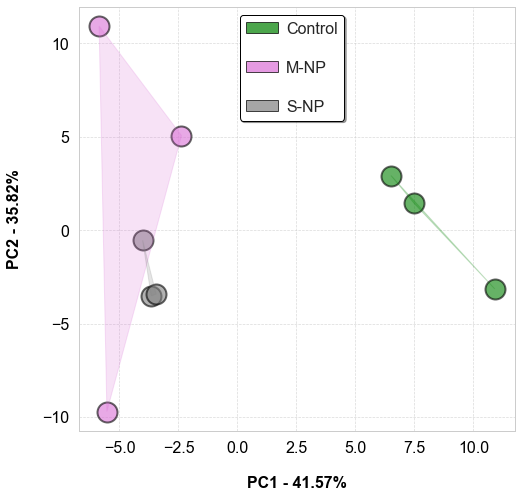

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch


data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()

color_map = {
    'Control': 'green',     
    'M-NP': 'orchid',    

}

plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


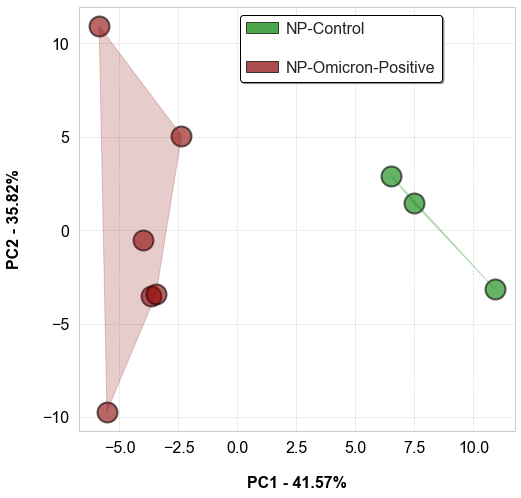

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

NI = data[[col for col in data.columns if col.startswith('Control')]]
Covid_Positive = data[[col for col in data.columns if col.startswith('M-NP') or col.startswith('S-NP')]]

data = pd.concat([NI, Covid_Positive], axis=1)

data_transposed = data.transpose()[concatenated_list]

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

def get_group(x):
    if x.startswith('Control'):
        return 'NP-Control'
    elif x.startswith('M-NP') or x.startswith('S-NP'):
        return 'NP-Omicron-Positive'
    else:
        return 'Other'

pca_df['Group'] = pca_df.index.to_series().apply(get_group)
groups = pca_df['Group'].unique()

color_map = {
    'NP-Control': 'green',
    'NP-Omicron-Positive': 'darkred'
}

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]
legend = ax.legend(handles=legend_elements, fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


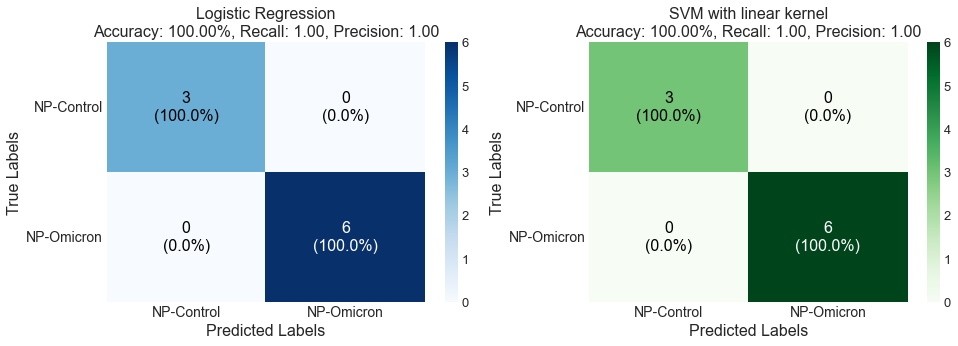

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

group_labels = ['NP-Control'] * NI.shape[1] + ['NP-Omicron'] * Covid_Positive.shape[1]

data = pd.concat([NI, Covid_Positive], axis=1)


data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = group_labels
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(group_labels)  
principal_df['Group'] = le.inverse_transform(y)  



X = principal_df.drop(columns=['Group'])

y = le.fit_transform(group_labels)


log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
class_names = le.classes_  
sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log, fontsize=16)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(class_names, fontsize=14)
ax[0].set_yticklabels(class_names, fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm, fontsize=16)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(class_names, fontsize=14)
ax[1].set_yticklabels(class_names, fontsize=14, rotation=0)

plt.tight_layout()
plt.show()
conf_matrix_log_GSE166190 =conf_matrix_log
accuracy_log_GSE166190 = accuracy_log
recall_log_GSE166190 = recall_log
precision_log_GSE166190 = precision_log
conf_matrix_svm_GSE166190 =conf_matrix_svm
accuracy_svm_GSE166190 = accuracy_svm
recall_svm_GSE166190 = recall_svm
precision_svm_GSE166190 = precision_svm

In [70]:

ALL = pd.read_csv('GSE294888-Ready.csv')



data = ALL.set_index('Gene Symbol')

data

,1_pDC_NI,1_pDC_NI_first,10_DC2_R848_first,10_pDC_R848,11_DC2_delta_first,11_pDC_delta,12_DC2_BA1_first,12_pDC_BA1,13_DC2_NI,13_pDC_NI_first,...,5_DC2_NI_first,5_pDC_NI,6_DC2_R848_first,6_pDC_R848,7_DC2_delta_first,7_pDC_delta,8_DC2_BA1_first,8_pDC_BA1,9_DC2_NI_first,9_pDC_NI
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,789.98400,403.5450,1.790100e+02,752.193,2.184550e+02,510.1250,1.303170e+02,5.309100e+02,644.04200,427.8750,...,4.095760e+02,990.092,2.964690e+02,9.099470e+02,2.934120e+02,572.1370,206.8820,444.260000,364.1860,7.781230e+02
A1BG-AS1,345.74800,252.2920,1.302160e+02,621.893,1.911910e+02,479.4740,1.573400e+02,5.108820e+02,490.65700,227.9600,...,2.242990e+02,846.634,2.668590e+02,1.056960e+03,2.693780e+02,548.6130,172.2160,436.048000,335.0270,6.040040e+02
A1CF,0.00000,0.0000,7.240000e-08,0.000,6.230000e-08,0.0000,1.410000e-07,1.990000e-08,0.00000,0.0000,...,1.180000e-07,0.000,2.210000e-08,4.170000e-08,1.980000e-08,0.0000,0.0000,0.026286,0.0000,4.940000e-08
A2M,2488.80000,338.6790,0.000000e+00,517.025,2.494290e+02,843.7480,2.782840e+01,4.387360e+02,40036.10000,119.4420,...,5.249000e+03,545.736,4.967510e+00,2.347480e+02,4.177060e+02,1586.0700,14.5672,532.751000,10675.3000,1.847890e+04
A2M-AS1,0.00000,0.0000,4.000000e+00,0.000,0.000000e+00,16.9167,0.000000e+00,0.000000e+00,22.52630,0.0000,...,0.000000e+00,68.617,0.000000e+00,1.614550e+01,0.000000e+00,18.9414,6.0000,18.532000,24.3669,2.952330e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.00000,0.0000,0.000000e+00,0.000,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.00000,0.0000,...,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.000000,0.0000,0.000000e+00
ZYG11B,1110.16000,644.3600,3.047300e+02,1153.700,3.842960e+02,949.8570,3.236700e+02,7.581330e+02,4890.81000,796.6730,...,1.107400e+03,2095.710,5.633830e+02,1.286640e+03,7.478230e+02,591.5630,395.8630,646.069000,1652.3000,2.013110e+03
ZYX,4801.24200,3533.7400,3.853520e+03,8090.480,1.084048e+04,5667.2300,9.591910e+03,6.147170e+03,18411.06000,3180.8900,...,1.121416e+04,5903.120,9.059260e+03,7.956650e+03,1.806294e+04,4065.4800,11533.7400,3846.800000,11449.3100,1.530387e+04


In [71]:
import re

original_columns = [
    '1_pDC_NI', '1_pDC_NI_first', '10_DC2_R848_first', '10_pDC_R848',
    '11_DC2_delta_first', '11_pDC_delta', '12_DC2_BA1_first', '12_pDC_BA1',
    '13_DC2_NI', '13_pDC_NI_first', '14_DC2_R848', '14_pDC_R848_first',
    '15_DC2_delta', '15_pDC_delta_first', '16_DC2_BA1', '16_pDC_BA1_first',
    '17_DC2_NI', '18_DC2_R848', '19_DC2_delta', '2_pDC_R848',
    '2_pDC_R848_first', '20_DC2_BA1', '21_DC2_NI', '22_DC2_R848',
    '23_DC2_delta', '24_DC2_BA1', '3_pDC_delta', '3_pDC_delta_first',
    '4_pDC_BA1', '4_pDC_BA1_first', '5_DC2_NI_first', '5_pDC_NI',
    '6_DC2_R848_first', '6_pDC_R848', '7_DC2_delta_first', '7_pDC_delta',
    '8_DC2_BA1_first', '8_pDC_BA1', '9_DC2_NI_first', '9_pDC_NI'
]
condition_map = {
    'NI': 'non-infected',
    'R848': 'TLR7/8',
    'delta': 'Delta',
    'BA1': 'Omicron'
}

replicate_counters = {}

new_columns = []
for col in original_columns:
    if 'pDC' in col:
        cell_type = 'pDC'
    elif 'DC2' in col:
        cell_type = 'DC2'
    else:
        cell_type = 'Unknown'

    treatment_found = False
    for key, treatment in condition_map.items():
        if re.search(key, col, re.IGNORECASE):
            pair_key = f"{cell_type}-{treatment}"
            replicate_counters[pair_key] = replicate_counters.get(pair_key, 0) + 1
            new_columns.append(f"{pair_key} ({replicate_counters[pair_key]})")
            treatment_found = True
            break

    if not treatment_found:
        new_columns.append(col)  

new_columns


['pDC-non-infected (1)',
 'pDC-non-infected (2)',
 'DC2-TLR7/8 (1)',
 'pDC-TLR7/8 (1)',
 'DC2-Delta (1)',
 'pDC-Delta (1)',
 'DC2-Omicron (1)',
 'pDC-Omicron (1)',
 'DC2-non-infected (1)',
 'pDC-non-infected (3)',
 'DC2-TLR7/8 (2)',
 'pDC-TLR7/8 (2)',
 'DC2-Delta (2)',
 'pDC-Delta (2)',
 'DC2-Omicron (2)',
 'pDC-Omicron (2)',
 'DC2-non-infected (2)',
 'DC2-TLR7/8 (3)',
 'DC2-Delta (3)',
 'pDC-TLR7/8 (3)',
 'pDC-TLR7/8 (4)',
 'DC2-Omicron (3)',
 'DC2-non-infected (3)',
 'DC2-TLR7/8 (4)',
 'DC2-Delta (4)',
 'DC2-Omicron (4)',
 'pDC-Delta (3)',
 'pDC-Delta (4)',
 'pDC-Omicron (3)',
 'pDC-Omicron (4)',
 'DC2-non-infected (4)',
 'pDC-non-infected (4)',
 'DC2-TLR7/8 (5)',
 'pDC-TLR7/8 (5)',
 'DC2-Delta (5)',
 'pDC-Delta (5)',
 'DC2-Omicron (5)',
 'pDC-Omicron (5)',
 'DC2-non-infected (5)',
 'pDC-non-infected (5)']

In [72]:
data.columns = [
    'pDC-non-infected (1)', 'pDC-non-infected (2)', 'DC2-TLR7/8 (1)', 'pDC-TLR7/8 (1)',
    'DC2-Delta (1)', 'pDC-Delta (1)', 'DC2-Omicron (1)', 'pDC-Omicron (1)',
    'DC2-non-infected (1)', 'pDC-non-infected (3)', 'DC2-TLR7/8 (2)', 'pDC-TLR7/8 (2)',
    'DC2-Delta (2)', 'pDC-Delta (2)', 'DC2-Omicron (2)', 'pDC-Omicron (2)',
    'DC2-non-infected (2)', 'DC2-TLR7/8 (3)', 'DC2-Delta (3)', 'pDC-TLR7/8 (3)',
    'pDC-TLR7/8 (4)', 'DC2-Omicron (3)', 'DC2-non-infected (3)', 'DC2-TLR7/8 (4)',
    'DC2-Delta (4)', 'DC2-Omicron (4)', 'pDC-Delta (3)', 'pDC-Delta (4)',
    'pDC-Omicron (3)', 'pDC-Omicron (4)', 'DC2-non-infected (4)', 'pDC-non-infected (4)',
    'DC2-TLR7/8 (5)', 'pDC-TLR7/8 (5)', 'DC2-Delta (5)', 'pDC-Delta (5)',
    'DC2-Omicron (5)', 'pDC-Omicron (5)', 'DC2-non-infected (5)', 'pDC-non-infected (5)'
]

data.columns = new_columns

In [73]:
data_pDC = data[[col for col in data.columns if col.startswith("pDC")]]
data_DC2 = data[[col for col in data.columns if col.startswith("DC2")]]

data_pDC.shape, data_DC2.shape


((24634, 20), (24634, 20))

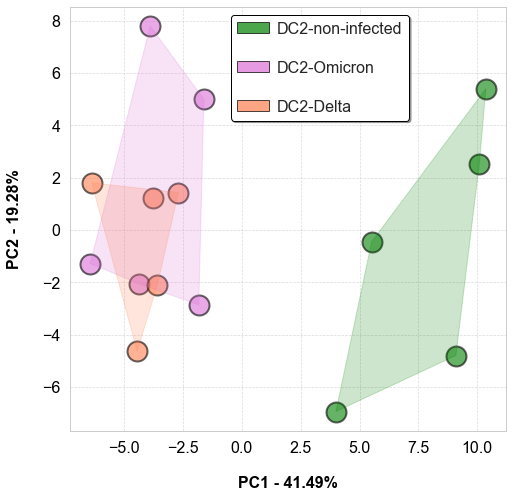

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

NI = data_DC2[[col for col in data_DC2.columns if col.startswith('DC2-non-infected')]]
Omicron = data_DC2[[col for col in data_DC2.columns if col.startswith('DC2-Omicron')]]
Delta= data_DC2[[col for col in data_DC2.columns if col.startswith('DC2-Delta')]]

data=pd.concat([NI,Omicron,Delta],axis=1)
data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()

color_map = {
    'DC2-non-infected': 'green',     
    'DC2-Omicron': 'orchid',   
    'DC2-Delta': 'coral', 

}

plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)


ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


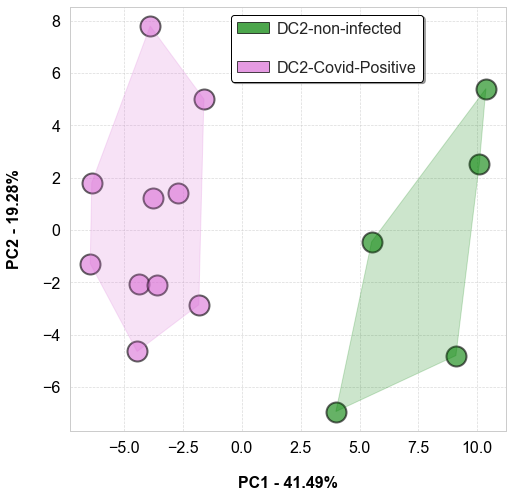

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

NI = data_DC2[[col for col in data_DC2.columns if col.startswith('DC2-non-infected')]]
Covid_Positive = data_DC2[[col for col in data_DC2.columns if col.startswith('DC2-Omicron') or col.startswith('DC2-Delta')]]

data = pd.concat([NI, Covid_Positive], axis=1)

data_transposed = data.transpose()[concatenated_list]

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

def get_group(x):
    if x.startswith('DC2-non-infected'):
        return 'DC2-non-infected'
    elif x.startswith('DC2-Omicron') or x.startswith('DC2-Delta'):
        return 'DC2-Covid-Positive'
    else:
        return 'Other'

pca_df['Group'] = pca_df.index.to_series().apply(get_group)
groups = pca_df['Group'].unique()

color_map = {
    'DC2-non-infected': 'green',
    'DC2-Covid-Positive': 'orchid'
}

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]
legend = ax.legend(handles=legend_elements, fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


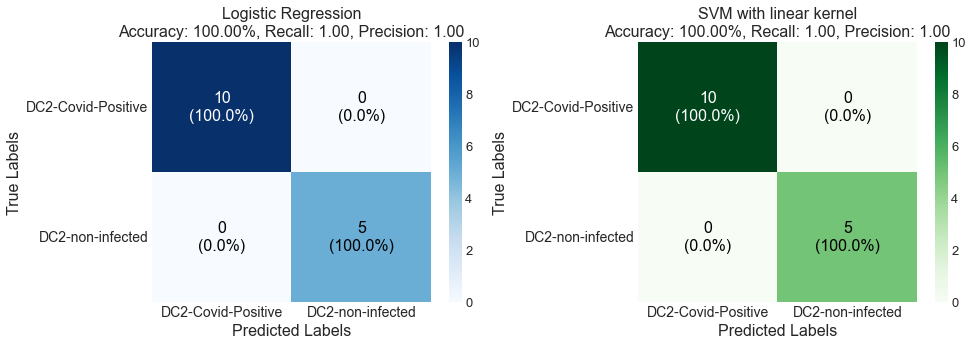

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

group_labels = ['DC2-non-infected'] * NI.shape[1] + ['DC2-Covid-Positive'] * Covid_Positive.shape[1]

data = pd.concat([NI, Covid_Positive], axis=1)


data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = group_labels
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(group_labels) 
principal_df['Group'] = le.inverse_transform(y)  



X = principal_df.drop(columns=['Group'])
y = le.fit_transform(group_labels)

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
class_names = le.classes_  
sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log, fontsize=16)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(class_names, fontsize=14)
ax[0].set_yticklabels(class_names, fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm, fontsize=16)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(class_names, fontsize=14)
ax[1].set_yticklabels(class_names, fontsize=14, rotation=0)

plt.tight_layout()
plt.show()
conf_matrix_log_GSE166190 =conf_matrix_log
accuracy_log_GSE166190 = accuracy_log
recall_log_GSE166190 = recall_log
precision_log_GSE166190 = precision_log
conf_matrix_svm_GSE166190 =conf_matrix_svm
accuracy_svm_GSE166190 = accuracy_svm
recall_svm_GSE166190 = recall_svm
precision_svm_GSE166190 = precision_svm

In [77]:
data

,DC2-non-infected (1),DC2-non-infected (2),DC2-non-infected (3),DC2-non-infected (4),DC2-non-infected (5),DC2-Delta (1),DC2-Omicron (1),DC2-Delta (2),DC2-Omicron (2),DC2-Delta (3),DC2-Omicron (3),DC2-Delta (4),DC2-Omicron (4),DC2-Delta (5),DC2-Omicron (5)
Gene Symbol,,,,,,,,,,,,,,,
A1BG,644.04200,461.5470,5.542570e+02,4.095760e+02,364.1860,2.184550e+02,1.303170e+02,3.244820e+02,3.421750e+02,5.413500e+02,5.089700e+02,2.860120e+02,374.551000,2.934120e+02,206.8820
A1BG-AS1,490.65700,429.9660,4.262970e+02,2.242990e+02,335.0270,1.911910e+02,1.573400e+02,1.961680e+02,2.514370e+02,5.307330e+02,4.662790e+02,2.774750e+02,233.754000,2.693780e+02,172.2160
A1CF,0.00000,0.0000,4.540000e-08,1.180000e-07,0.0000,6.230000e-08,1.410000e-07,7.020000e-08,5.380000e-08,1.540000e-07,1.170000e-08,3.510000e-08,0.000000,1.980000e-08,0.0000
A2M,40036.10000,39560.2000,4.816770e+04,5.249000e+03,10675.3000,2.494290e+02,2.782840e+01,9.210000e+02,2.757880e+01,2.239560e+03,1.120000e+02,1.401550e+03,120.375000,4.177060e+02,14.5672
A2M-AS1,22.52630,57.9707,3.837020e+01,0.000000e+00,24.3669,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000002,0.000000e+00,6.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.00000,0.0000,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0000
ZYG11B,4890.81000,2692.0400,3.415210e+03,1.107400e+03,1652.3000,3.842960e+02,3.236700e+02,7.527480e+02,1.248780e+03,8.403490e+02,1.071230e+03,7.162130e+02,749.003000,7.478230e+02,395.8630
ZYX,18411.06000,16810.1100,1.990926e+04,1.121416e+04,11449.3100,1.084048e+04,9.591910e+03,1.219741e+04,1.871970e+04,2.860680e+04,3.434450e+04,2.126280e+04,22409.200000,1.806294e+04,11533.7400


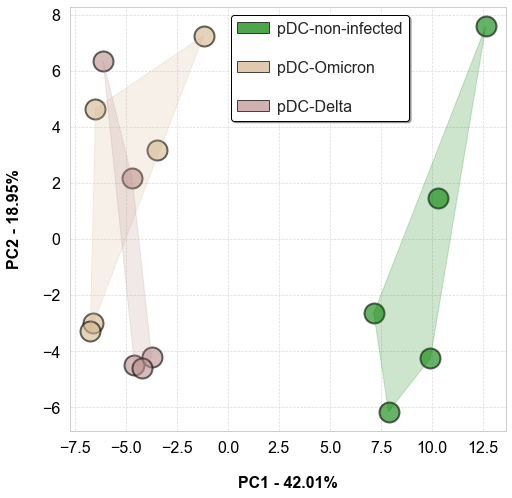

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

NI = data_pDC[[col for col in data_pDC.columns if col.startswith('pDC-non-infected')]]
Omicron = data_pDC[[col for col in data_pDC.columns if col.startswith('pDC-Omicron')]]
Delta= data_pDC[[col for col in data_pDC.columns if col.startswith('pDC-Delta')]]

data=pd.concat([NI,Omicron,Delta],axis=1)
data_transposed = data.transpose()[concatenated_list]
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)


pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

pca_df['Group'] = pca_df.index.to_series().apply(lambda x: x.split('(')[0].strip())
groups = pca_df['Group'].unique()

color_map = {
    'pDC-non-infected': 'green',     
    'pDC-Omicron': 'tan',    
    'pDC-Delta': 'rosybrown', 

}

plt.style.use('seaborn-whitegrid')
from scipy.spatial import ConvexHull

fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)


legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]

legend = ax.legend(handles=legend_elements,  fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


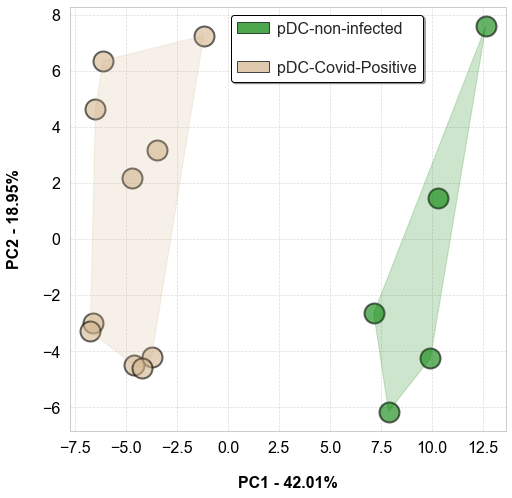

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

NI = data_pDC[[col for col in data_pDC.columns if col.startswith('pDC-non-infected')]]
Covid_Positive = data_pDC[[col for col in data_pDC.columns if col.startswith('pDC-Omicron') or col.startswith('pDC-Delta')]]

data = pd.concat([NI, Covid_Positive], axis=1)

data_transposed = data.transpose()[concatenated_list]

scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

# 
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
explained_variance_percentages = ['{:.2%}'.format(v) for v in explained_variance]

pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'], index=data_transposed.index)

def get_group(x):
    if x.startswith('pDC-non-infected'):
        return 'pDC-non-infected'
    elif x.startswith('pDC-Omicron') or x.startswith('pDC-Delta'):
        return 'pDC-Covid-Positive'
    else:
        return 'Other'

pca_df['Group'] = pca_df.index.to_series().apply(get_group)
groups = pca_df['Group'].unique()

color_map = {
    'pDC-non-infected': 'green',
    'pDC-Covid-Positive': 'tan'
}

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(7.8, 7.8))

for label in groups:
    indices = pca_df['Group'] == label
    points = pca_df.loc[indices, ['PC1', 'PC2']].values
    ax.scatter(points[:, 0], points[:, 1],
               s=400, color=color_map.get(label, 'gray'), label=label, edgecolor='black', alpha=0.6, linewidth=2)
    if len(points) > 2:
        hull = ConvexHull(points)
        hull_vertices = points[hull.vertices]
        ax.fill(hull_vertices[:, 0], hull_vertices[:, 1], color=color_map.get(label, 'gray'), alpha=0.2)

ax.set_xlabel(f'PC1 - {explained_variance_percentages[0]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.set_ylabel(f'PC2 - {explained_variance_percentages[1]}', fontsize=16, labelpad=20, fontweight='bold', color='black')
ax.tick_params(axis='both', which='major', labelsize=16, colors='black', pad=10, width=2)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

legend_elements = [Patch(facecolor=color_map.get(label, 'gray'), edgecolor='black', label=label, alpha=0.7) for label in groups]
legend = ax.legend(handles=legend_elements, fontsize=16, title_fontsize=14, loc='upper left',
                   bbox_to_anchor=(0.35, 1), ncol=1, frameon=True, edgecolor='black', columnspacing=1.5,
                   handletextpad=0.5, labelspacing=1.5, fancybox=True, shadow=True, framealpha=1)

plt.show()


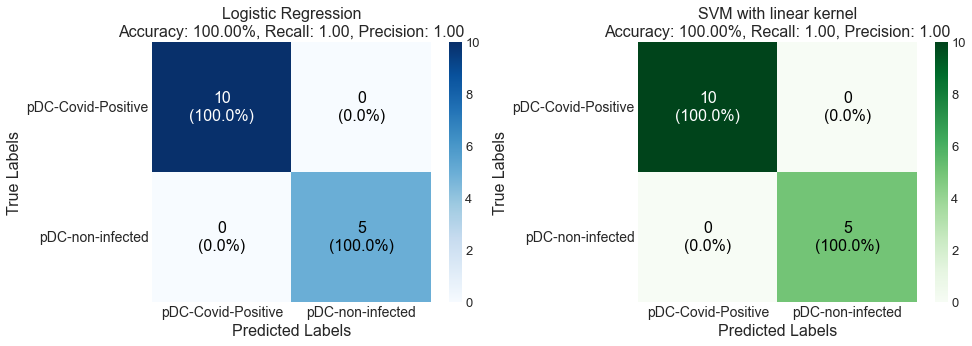

In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

group_labels = ['pDC-non-infected'] * NI.shape[1] + ['pDC-Covid-Positive'] * Covid_Positive.shape[1]

data = pd.concat([NI, Covid_Positive], axis=1)


data_transposed = data.transpose()[concatenated_list]
scaler = StandardScaler()
data_scaled = np.log2(data_transposed + 1)

pca = PCA(n_components=5)
principal_components = pca.fit_transform(data_scaled)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=[f'PC{i+1}' for i in range(5)], 
                            index=data_transposed.index)

principal_df['Group'] = group_labels
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(group_labels)  
principal_df['Group'] = le.inverse_transform(y) 



X = principal_df.drop(columns=['Group'])
y = le.fit_transform(group_labels)

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred_log = log_reg.predict(X)
conf_matrix_log = confusion_matrix(y, y_pred_log)
accuracy_log = accuracy_score(y, y_pred_log)
recall_log = recall_score(y, y_pred_log)
precision_log = precision_score(y, y_pred_log)

svm = SVC(kernel='linear', probability=True)
svm.fit(X, y)
y_pred_svm = svm.predict(X)
conf_matrix_svm = confusion_matrix(y, y_pred_svm)
accuracy_svm = accuracy_score(y, y_pred_svm)
recall_svm = recall_score(y, y_pred_svm)
precision_svm = precision_score(y, y_pred_svm)

def add_percentage(cm, ax):
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = f'{(cm[i, j]/row_sum*100):.1f}%'
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j+.5, i+.5, f'{cm[i, j]}\n({percentage})', ha='center', va='center', color=text_color, fontsize=16)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
class_names = le.classes_  
sns.heatmap(conf_matrix_log, annot=False, ax=ax[0], cmap="Blues", fmt='g')
add_percentage(conf_matrix_log, ax[0])
title_log = f'Logistic Regression\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_log:.2f}, Precision: {precision_log:.2f}'
ax[0].set_title(title_log, fontsize=16)
ax[0].set_xlabel('Predicted Labels', fontsize=16)
ax[0].set_ylabel('True Labels', fontsize=16)
ax[0].set_xticklabels(class_names, fontsize=14)
ax[0].set_yticklabels(class_names, fontsize=14, rotation=0)

sns.heatmap(conf_matrix_svm, annot=False, ax=ax[1], cmap="Greens", fmt='g')
add_percentage(conf_matrix_svm, ax[1])
title_svm = f'SVM with linear kernel\nAccuracy: {accuracy_log*100:.2f}%, Recall: {recall_svm:.2f}, Precision: {precision_svm:.2f}'
ax[1].set_title(title_svm, fontsize=16)
ax[1].set_xlabel('Predicted Labels', fontsize=16)
ax[1].set_ylabel('True Labels', fontsize=16)
ax[1].set_xticklabels(class_names, fontsize=14)
ax[1].set_yticklabels(class_names, fontsize=14, rotation=0)

plt.tight_layout()
plt.show()
conf_matrix_log_GSE166190 =conf_matrix_log
accuracy_log_GSE166190 = accuracy_log
recall_log_GSE166190 = recall_log
precision_log_GSE166190 = precision_log
conf_matrix_svm_GSE166190 =conf_matrix_svm
accuracy_svm_GSE166190 = accuracy_svm
recall_svm_GSE166190 = recall_svm
precision_svm_GSE166190 = precision_svm